# Assignment 1 2AMM10 2024-2025

## Group: YXY
### Member 1: Andy Wei 2135663
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

In [1]:
import os
import pandas as pd
import torch 
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub
import torchvision.transforms as transforms

# add additonal imports here
class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir,column_class="articleTypeId", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg")  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

c:\Users\Andy\DP_assignment1\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download data with kagglehub

In [2]:
# import shutil
# import os

dataset_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
img_dir = os.path.join(dataset_path,"images")

# shutil.rmtree(dataset_path)

The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.

In [3]:
dataset = FashionDataset("dataset/train.csv",img_dir)

In [4]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


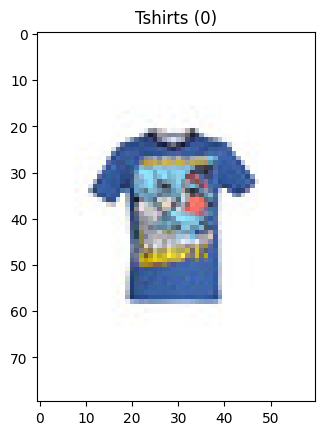

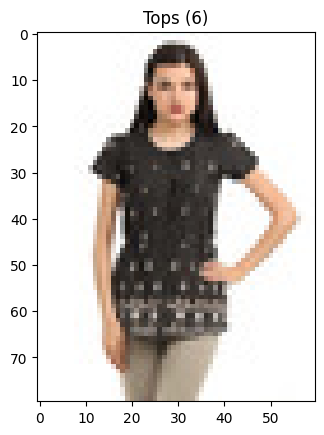

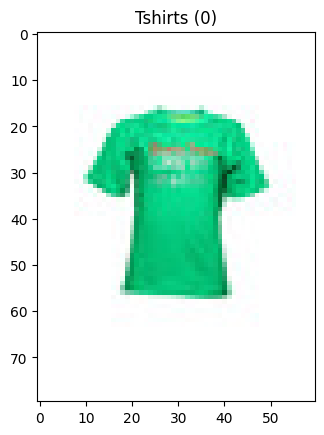

In [5]:
np.random.seed(42)
random_indices = np.random.choice(len(dataset),3)

for i in random_indices:
    img, label = dataset[i]
    plt.title(dataset.df.iloc[i]["articleTypeName"]+f" ({label.item()})")
    plt.imshow(img)
    plt.show()

## Loading different datasets

In [6]:
transform = transforms.Compose([
    transforms.Resize((60, 80)),
    # transforms.RandomHorizontalFlip(p=0.3),
    # transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# transform = transforms.Compose([
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(degrees=15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)


label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)} 
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

## Task 1

In [7]:
# your solution
# train dataset: train_dataset
# test datset: main_test_dataset

In [8]:
# define network archietecture

class FashionNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(FashionNet, self).__init__()

        # convolutional layers
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size = 3, padding = 1)

        # batch normalization layers
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.bn3 = torch.nn.BatchNorm2d(128)

        # pooling layer
        self.pool = torch.nn.MaxPool2d(2, 2)

        # dropout layer
        self.dropout_light = torch.nn.Dropout(0.1)
        self.dropout = torch.nn.Dropout(0.25)

        # fully conneted layer
        # self.fc1 = torch.nn.Linear(128 * 28 * 28, 512)
        self.fc1 = torch.nn.Linear(128 * 7 * 10, 512)
        self.fc2 = torch.nn.Linear(512, num_classes)

        # activation function
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout_light(x) 
        x = self.pool(x)
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with dropout
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x # already without softmax => can be used as a feature

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001, restore_best_weights=True):

        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
                print("Early stopping triggered. Restored best weights.")

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()


Training

In [9]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.amp import autocast, GradScaler

# hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-4
weight_decay = 1e-4

# create data loader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(main_test_dataset, batch_size = batch_size, shuffle = False)

num_classes = len(train_dataset.df['articleTypeId'].unique())

# initialize the model
model = FashionNet(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Improved training function with AMP
def train_model(model, train_loader, test_loader, device, epochs=10):
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

    # Initialize gradient scaler for AMP
    scaler = GradScaler()
    
    # Initialize Early Stopping
    early_stopping = EarlyStopping(patience=3, min_delta=0.001)
    
    # Track best model
    best_test_acc = 0.0
    
    print(f"Starting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            
            # Use AMP autocast
            with autocast(device_type='cuda', enabled=torch.cuda.is_available()):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            # Scale gradients and perform backward pass
            scaler.scale(loss).backward()
            
            # Update weights with scaled gradients
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
            
            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{(train_correct/train_total):.4f}'
            })
        
        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        
        # Test phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        test_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} [Test]')
        
        with torch.no_grad():
            for inputs, labels in test_pbar:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()
                
                test_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{(test_correct/test_total):.4f}'
                })
        
        test_loss = test_loss / len(test_loader)
        test_acc = test_correct / test_total
        
        # Update learning rate based on test accuracy
        scheduler.step(test_acc)
        
        # Early stopping check 
        early_stopping(test_loss, model)
        
        # Print results
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print(f'Early Stopping Counter: {early_stopping.counter}/{early_stopping.patience}')

        # Clean GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Save best model
        if test_acc > best_test_acc: 
            best_test_acc = test_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"New best test accuracy: {test_acc:.4f}")
        
        # Check for early stopping 
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print(f"Training completed! Best test accuracy: {best_test_acc:.4f}")
    return model

In [10]:
print(f"Using device: {device}")
model = train_model(model, train_loader, test_loader, device, 10)

Using device: cuda
Starting training for 10 epochs...


Epoch 1/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 54.76it/s, loss=0.9552, acc=0.8187]


Epoch 1/10:
Train Loss: 1.4520, Train Acc: 0.7365
Test Loss: 1.1783, Test Acc: 0.8187
Early Stopping Counter: 0/3
New best test accuracy: 0.8187


Epoch 2/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 59.67it/s, loss=0.8347, acc=0.8478]


Epoch 2/10:
Train Loss: 1.1569, Train Acc: 0.8372
Test Loss: 1.0905, Test Acc: 0.8478
Early Stopping Counter: 0/3
New best test accuracy: 0.8478


Epoch 3/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 57.95it/s, loss=0.8436, acc=0.8573]


Epoch 3/10:
Train Loss: 1.0814, Train Acc: 0.8634
Test Loss: 1.0659, Test Acc: 0.8573
Early Stopping Counter: 0/3
New best test accuracy: 0.8573


Epoch 4/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 60.35it/s, loss=0.8642, acc=0.8733]


Epoch 4/10:
Train Loss: 1.0323, Train Acc: 0.8829
Test Loss: 1.0355, Test Acc: 0.8733
Early Stopping Counter: 0/3
New best test accuracy: 0.8733


Epoch 5/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 60.12it/s, loss=0.8550, acc=0.8783]


Epoch 5/10:
Train Loss: 0.9945, Train Acc: 0.8979
Test Loss: 1.0143, Test Acc: 0.8783
Early Stopping Counter: 0/3
New best test accuracy: 0.8783


Epoch 6/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 58.86it/s, loss=0.8429, acc=0.8903]


Epoch 6/10:
Train Loss: 0.9679, Train Acc: 0.9078
Test Loss: 1.0010, Test Acc: 0.8903
Early Stopping Counter: 0/3
New best test accuracy: 0.8903


Epoch 7/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 59.61it/s, loss=0.8265, acc=0.8933]


Epoch 7/10:
Train Loss: 0.9433, Train Acc: 0.9171
Test Loss: 0.9882, Test Acc: 0.8933
Early Stopping Counter: 0/3
New best test accuracy: 0.8933


Epoch 8/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 60.34it/s, loss=0.8529, acc=0.8893]


Epoch 8/10:
Train Loss: 0.9229, Train Acc: 0.9271
Test Loss: 0.9977, Test Acc: 0.8893
Early Stopping Counter: 1/3


Epoch 9/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 59.30it/s, loss=0.8423, acc=0.8893]


Epoch 9/10:
Train Loss: 0.9045, Train Acc: 0.9340
Test Loss: 0.9834, Test Acc: 0.8893
Early Stopping Counter: 0/3


Epoch 10/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 58.75it/s, loss=0.7603, acc=0.8958]

Epoch 10/10:
Train Loss: 0.8880, Train Acc: 0.9424
Test Loss: 0.9723, Test Acc: 0.8958
Early Stopping Counter: 0/3
New best test accuracy: 0.8958
Training completed! Best test accuracy: 0.8958


In [11]:
from sklearn.metrics import balanced_accuracy_score
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to track gradients
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Regular accuracy
    accuracy = 100 * correct / total
    # Balanced accuracy
    balanced_acc = 100 * balanced_accuracy_score(all_labels, all_preds)
    
    return accuracy, balanced_acc

# After training your model
acc, bal_acc = evaluate_model(model, test_loader, device)
print(f'Accuracy: {acc:.2f}%')
print(f'Balanced Accuracy: {bal_acc:.2f}%')

Accuracy: 89.58%
Balanced Accuracy: 83.75%


## Task 2

In [12]:
# your solution
# train dataset: train_dataset
# test and support dataset: see scenarios table

In [13]:
import torch.nn.functional as F
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)

In [14]:
class FashionNetT2(torch.nn.Module):
    def __init__(self, embedding_dim=256):
        super(FashionNetT2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.embedding_dim = embedding_dim
        self.fc1 = nn.Linear(128 * 7 * 10, 512)
        self.fc2 = nn.Linear(512, embedding_dim)  # Now outputs a feature vector

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        embedding = self.fc2(x)  # Output feature vector
        return embedding
    


In [15]:
def train_triplet_model(model, triplet_loader, device, epochs=10):
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
        criterion = nn.TripletMarginLoss(margin=1.0, p=2)

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0

            for anchor, positive, negative in tqdm(triplet_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

                optimizer.zero_grad()

                emb_a = model(anchor)
                emb_p = model(positive)
                emb_n = model(negative)

                loss = criterion(emb_a, emb_p, emb_n)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            print(f"Epoch {epoch+1}, Loss: {running_loss/len(triplet_loader):.4f}")
        torch.save(model.state_dict(), 'task2_model.pth')



In [16]:
from torch.utils.data import Dataset
import random
from collections import defaultdict
class TripletFashionDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.labels = base_dataset.targets
        self.label_to_indices = self._build_index()

    def _build_index(self):
        label_to_indices = defaultdict(list)
        for idx, label in enumerate(self.labels):
            label_to_indices[label].append(idx)
        return label_to_indices

    def __getitem__(self, index):
        anchor_img, anchor_label = self.base_dataset[index]

        # Positive sample
        positive_index = index
        while positive_index == index:
            positive_index = random.choice(self.label_to_indices[anchor_label])
        positive_img, _ = self.base_dataset[positive_index]

        # Negative sample
        negative_label = anchor_label
        while negative_label == anchor_label:
            negative_label = random.choice(list(self.label_to_indices.keys()))
        negative_index = random.choice(self.label_to_indices[negative_label])
        negative_img, _ = self.base_dataset[negative_index]

        return anchor_img, positive_img, negative_img

    def __len__(self):
        return len(self.base_dataset)

In [17]:
# Use your existing dataset
triplet_dataset = TripletFashionDataset(train_dataset)
triplet_loader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)

# Train the model with triplet loss

model_2 = FashionNetT2(embedding_dim=128)
train_triplet_model(model_2, triplet_loader, device, epochs=10)


Epoch 1/10: 100%|██████████| 1123/1123 [01:08<00:00, 16.35it/s]


Epoch 1, Loss: 0.1667


Epoch 2/10: 100%|██████████| 1123/1123 [01:09<00:00, 16.06it/s]


Epoch 2, Loss: 0.0744


Epoch 3/10: 100%|██████████| 1123/1123 [01:09<00:00, 16.09it/s]


Epoch 3, Loss: 0.0502


Epoch 4/10: 100%|██████████| 1123/1123 [01:43<00:00, 10.87it/s]


Epoch 4, Loss: 0.0438


Epoch 5/10: 100%|██████████| 1123/1123 [01:14<00:00, 15.12it/s]


Epoch 5, Loss: 0.0365


Epoch 6/10: 100%|██████████| 1123/1123 [01:26<00:00, 12.99it/s]


Epoch 6, Loss: 0.0362


Epoch 7/10: 100%|██████████| 1123/1123 [02:19<00:00,  8.05it/s]


Epoch 7, Loss: 0.0408


Epoch 8/10: 100%|██████████| 1123/1123 [01:24<00:00, 13.34it/s]


Epoch 8, Loss: 0.0280


Epoch 9/10: 100%|██████████| 1123/1123 [01:08<00:00, 16.33it/s]


Epoch 9, Loss: 0.0288


Epoch 10/10: 100%|██████████| 1123/1123 [01:08<00:00, 16.40it/s]

Epoch 10, Loss: 0.0240


In [18]:
# Support Set Embedding
def compute_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Computing embeddings"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            embeddings.append(outputs.cpu())
            labels.extend(targets.cpu().numpy())

    embeddings = torch.cat(embeddings).numpy()  # [N, D]
    return embeddings, labels
# KNN
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier

def classify_knn(support_embeddings, support_labels, test_embeddings, test_labels, k=1):
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(support_embeddings, support_labels)
    preds = knn.predict(test_embeddings)

    acc = accuracy_score(test_labels, preds) * 100
    bal_acc = balanced_accuracy_score(test_labels, preds) * 100
    return acc, bal_acc


In [62]:
# Scenario 1
support_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(main_test_dataset, batch_size=64, shuffle=False)
support_embeddings, support_labels = compute_embeddings(model_2, support_loader, device)
test_embeddings, test_labels = compute_embeddings(model_2, test_loader, device)


acc, bal_acc = classify_knn(support_embeddings, support_labels, test_embeddings, test_labels)

print(f"Test Accuracy: {acc:.2f}%, Balanced Accuracy: {bal_acc:.2f}%")


Computing embeddings: 100%|██████████| 32/32 [00:01<00:00, 26.26it/s]


Test Accuracy: 77.57%, Balanced Accuracy: 71.71%


In [20]:
# Scenario 2
support_loader = DataLoader(main_support_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(main_test_dataset, batch_size=64, shuffle=False)
support_embeddings, support_labels = compute_embeddings(model_2, support_loader, device)
test_embeddings, test_labels = compute_embeddings(model_2, test_loader, device)


acc, bal_acc = classify_knn(support_embeddings, support_labels, test_embeddings, test_labels)

print(f"Test Accuracy: {acc:.2f}%, Balanced Accuracy: {bal_acc:.2f}%")


Computing embeddings: 100%|██████████| 32/32 [00:01<00:00, 26.53it/s]

Test Accuracy: 71.56%, Balanced Accuracy: 64.57%


In [21]:
# Scenario 3
support_loader = DataLoader(new_support_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(new_test_dataset, batch_size=64, shuffle=False)
support_embeddings, support_labels = compute_embeddings(model_2, support_loader, device)
test_embeddings, test_labels = compute_embeddings(model_2, test_loader, device)

acc, bal_acc = classify_knn(support_embeddings, support_labels, test_embeddings, test_labels)
print(f"[Scenario 3] Accuracy: {acc:.2f}%, Balanced Accuracy: {bal_acc:.2f}%")


Computing embeddings: 100%|██████████| 26/26 [00:01<00:00, 15.53it/s]

[Scenario 3] Accuracy: 71.39%, Balanced Accuracy: 71.14%


In [22]:
# Scenario 4
support_loader = DataLoader(merged_support_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(merged_test_dataset, batch_size=64, shuffle=False)
support_embeddings, support_labels = compute_embeddings(model_2, support_loader, device)
test_embeddings, test_labels = compute_embeddings(model_2, test_loader, device)
acc, bal_acc = classify_knn(support_embeddings, support_labels, test_embeddings, test_labels)
print(f"[Scenario 4] Accuracy: {acc:.2f}%, Balanced Accuracy: {bal_acc:.2f}%")


Computing embeddings: 100%|██████████| 58/58 [00:02<00:00, 26.21it/s]


[Scenario 4] Accuracy: 64.45%, Balanced Accuracy: 59.38%


## Task 3

In [23]:
# your solution
# test dataset: merged_test_dataset
# support/catalog dataset: support_test_dataset

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

%matplotlib inline
plt.style.use('ggplot')

In [90]:
# methods to compute top-k and confidence values

In [91]:
def compute_confidence(similarities):
    return similarities[0] - similarities[2]

In [92]:
# plot func

In [93]:
def plot(error_rates,coverage_rates):
    plt.figure(figsize=(8, 6))
    plt.plot(error_rates, coverage_rates, marker='o', color='orange')
    plt.xlabel('Error Rate (%)')
    plt.ylabel('Coverage (%)')
    plt.title('Error Rate vs. Coverage')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [94]:
# evaluate recommendation func

In [96]:
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

def evaluate_recommendation(support_features,support_labels,test_features,test_labels):
    thresholds = np.linspace(0, 1, 42)
    error_rates = []
    coverage_rates = []

    # Nearest Neighbors model
    nn_model = NearestNeighbors(n_neighbors=3, metric='cosine')
    nn_model.fit(support_features)
    
    for threshold in tqdm(thresholds):
        total = len(test_features)
        shown = 0
        incorrect = 0
    
        for i, test_feature in enumerate(test_features):
            distances, indices = nn_model.kneighbors([test_feature], n_neighbors=3)
            similarities = 1 - distances[0]
            confidence = similarities[0] - similarities[2]    
            if confidence >= threshold:
                shown += 1
                recommended_labels = support_labels[indices[0]]
                if test_labels[i] not in recommended_labels:
                    incorrect += 1
    
        coverage = shown / total if total else 0
        error_rate = incorrect / shown if shown else 0
        coverage_rates.append(coverage * 100)
        error_rates.append(error_rate * 100)

    return thresholds,error_rates,coverage_rates

In [97]:
# Get features

In [99]:
import torch.nn.functional as F

def classify_by_nearest_neighbor(test_features, support_features, support_labels, metric='cosine'):
    predictions = []

    for test_feat in test_features:
        if metric == 'cosine':
            sims = F.cosine_similarity(test_feat.unsqueeze(0), support_features)
            idx = torch.argmax(sims).item()
        if metric == 'euclidean':
            dists = torch.norm(support_features - test_feat.unsqueeze(0), dim=1)
            idx = torch.argmin(dists).item()

        predictions.append(support_labels[idx])
    
    return predictions

In [100]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

def evaluate_predictions(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"Balanced Accuracy: {bal_acc * 100:.2f}%")
    return acc, bal_acc

In [101]:
def extract_features(model, dataloader, device):
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Extracting features"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu())
            labels.extend(targets.cpu().tolist())

    return torch.cat(features), labels

In [106]:
from torch.utils.data import DataLoader

merged_support_loader = DataLoader(merged_support_dataset, batch_size=32, shuffle=False)
merged_test_loader = DataLoader(merged_test_dataset, batch_size=32, shuffle=False)

support_features, support_labels = extract_features(model_2, merged_support_loader, device)
test_features, test_labels = extract_features(model_2, merged_test_loader, device)

Extracting features: 100%|██████████| 115/115 [00:01<00:00, 59.22it/s]


In [107]:
support_features = support_features.numpy()
test_features = test_features.numpy()
support_labels = np.array(support_labels)
test_labels = np.array(test_labels)

In [108]:
thresholds,error_rates,coverage_rates = evaluate_recommendation(support_features,support_labels,test_features,test_labels)

100%|██████████| 42/42 [03:20<00:00,  4.77s/it]


In [109]:
target_error = 10.0

for t, e, c in zip(thresholds, error_rates, coverage_rates):
    if e <= target_error:
        print(f"Threshold: {t:.3f}, Error Rate: {e:.2f}%, Coverage: {c:.2f}%")

Threshold: 0.049, Error Rate: 6.95%, Coverage: 7.08%
Threshold: 0.073, Error Rate: 2.83%, Coverage: 2.90%
Threshold: 0.098, Error Rate: 6.38%, Coverage: 1.29%
Threshold: 0.122, Error Rate: 4.55%, Coverage: 0.60%
Threshold: 0.146, Error Rate: 0.00%, Coverage: 0.25%
Threshold: 0.171, Error Rate: 0.00%, Coverage: 0.03%
Threshold: 0.195, Error Rate: 0.00%, Coverage: 0.03%
Threshold: 0.220, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.244, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.268, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.293, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.317, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.341, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.366, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.390, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.415, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.439, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.463, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.488, Error Rate: 0.00%, Coverage:

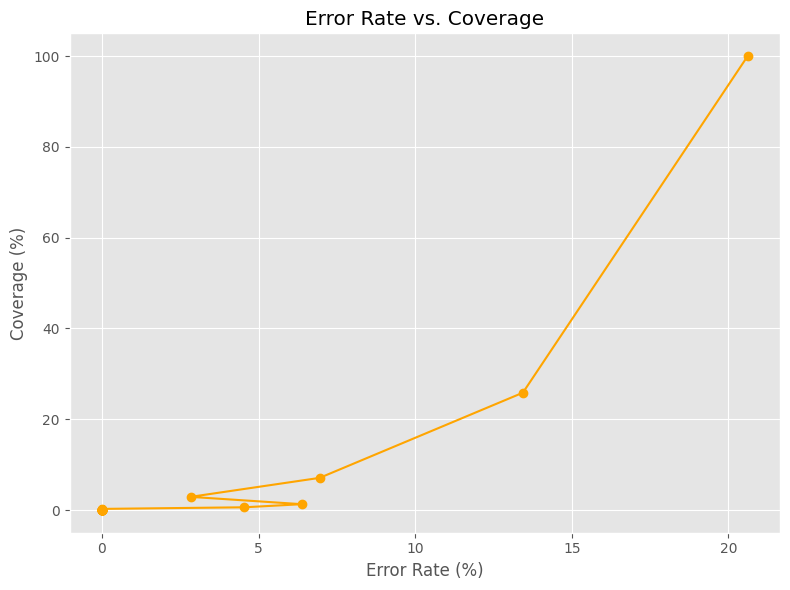

In [110]:
plot(error_rates,coverage_rates)

## Task 4

In [39]:
# your solution
# datasets: first 10 classes of train_dataset and main_test_dataset

In [41]:
# Import required libraries for dimensionality reduction and visualization
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import pandas as pd
from sklearn.metrics import pairwise_distances

In [45]:
# Load your trained Task 2 model
model_2 = FashionNetT2(embedding_dim=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2.to(device)
# try:
#     model_task2.load_state_dict(torch.load('model_task2.pth'))
#     print("Successfully loaded Task 2 model")
# except:
#     print("Warning: Could not load model_task2.pth. Make sure Task 2 training is complete.")
#     print("Using current model state...")
# model_task2 = model_task2.to(device)
# model_task2.eval()

FashionNetT2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=8960, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (relu): ReLU()
)

In [130]:
# Step1
def filter_dataset_first_10_classes_robust(dataset, max_class_id=9):
    """Robust filtering that handles index mismatches"""
    valid_indices = []
    
    print(f"Filtering dataset for classes 0-{max_class_id}...")
    
    # Check what classes are available first
    available_classes = set()
    for i in range(min(100, len(dataset))):  # Sample first 100 to check
        try:
            _, label = dataset[i]
            available_classes.add(label)
        except:
            continue
    
    print(f"Available classes in dataset: {sorted(available_classes)}")
    
    # Now filter for the desired classes
    for i in range(len(dataset)):
        try:
            _, label = dataset[i]
            if label <= max_class_id:
                valid_indices.append(i)
        except (KeyError, IndexError) as e:
            continue
    
    print(f"Found {len(valid_indices)} valid samples for first {max_class_id+1} classes")
    return Subset(dataset, valid_indices)

# Create filtered datasets for first 10 classes
print("Filtering train dataset...")
train_first_10 = filter_dataset_first_10_classes_robust(train_dataset, max_class_id=9)
main_support_first_10 = filter_dataset_first_10_classes_robust(main_support_dataset, max_class_id=9)
print("Filtering main test dataset...")
main_test_first_10 = filter_dataset_first_10_classes_robust(main_test_dataset, max_class_id=9)

# Create DataLoaders for the filtered datasets
train_first_10_loader = DataLoader(train_first_10, batch_size=32, shuffle=False)
main_test_first_10_loader = DataLoader(main_test_first_10, batch_size=32, shuffle=False)
main_support_first_10_loader = DataLoader(main_support_first_10, batch_size=32, shuffle=False)
print(f"Train dataset (first 10 classes): {len(train_first_10)} samples")
print(f"Main support dataset (first 10 classes): {len(main_support_first_10)} samples")
print(f"Test dataset (first 10 classes): {len(main_test_first_10)} samples")

Filtering train dataset...
Filtering dataset for classes 0-9...
Available classes in dataset: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(25), np.int64(29), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35)]
Found 22911 valid samples for first 10 classes
Filtering dataset for classes 0-9...
Available classes in dataset: [np.int64(0), np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(21), np.int64(22), np.int64(23), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(34), np.int64(35), np.int64(37

In [125]:
# Use your existing compute_embeddings function but rename for clarity
def extract_features_task4(model, dataloader, device):
    """Extract features using the trained Task 2 model"""
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Extracting features"):
            inputs = inputs.to(device)
            outputs = model(inputs)  # Get embeddings from Task 2 model
            features.append(outputs.cpu())
            labels.extend(targets.cpu().numpy())
    
    features = torch.cat(features).numpy()  # [N, embedding_dim]
    return features, np.array(labels)
def apply_tsne_visualization(features, labels, label_names, title_suffix=""):
    """
    Apply t-SNE dimensionality reduction and create scatter plot.
    t-SNE is a non-linear dimensionality reduction technique that preserves local structure 
    in the data, making it effective for visualizing high-dimensional feature representations.
    """
    print(f"Applying t-SNE to {len(features)} samples...")
    
    # Adjust perplexity based on dataset size
    perplexity = min(30, len(features) // 4)
    perplexity = max(5, perplexity)  # Ensure minimum perplexity
    
    # Apply t-SNE reduction
    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=perplexity,
        n_iter=1000,
        n_jobs=1
    )
    reduced_features = tsne.fit_transform(features)
    
    # Create scatter plot
    plt.figure(figsize=(14, 10))
    
    # Get unique classes and create color map
    unique_classes = sorted(set(labels))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))
    
    # Plot each class
    for i, class_id in enumerate(unique_classes):
        mask = labels == class_id
        if np.any(mask):
            class_name = label_names.get(class_id, f"Class {class_id}")
            plt.scatter(
                reduced_features[mask, 0],
                reduced_features[mask, 1],
                c=[colors[i]],
                label=f"{class_name} ({class_id})",
                alpha=0.7,
                s=40,
                edgecolors='black',
                linewidth=0.5
            )
    
    plt.title(f't-SNE Visualization of Task 2 Features - {title_suffix}', fontsize=16, fontweight='bold')
    plt.xlabel('t-SNE Component 1', fontsize=14)
    plt.ylabel('t-SNE Component 2', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return reduced_features



C:\Users\Andy\AppData\Local\Temp\ipykernel_21800\578045236.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_2.load_state_dict(torch.load('task2_model.pth'))


TASK 4, STEP 1: VISUALIZING THE FEATURE LANDSCAPE

1. Extracting features from training dataset (first 10 classes)...


Extracting features: 100%|██████████| 716/716 [00:17<00:00, 42.07it/s]



2. Extracting features from test dataset (first 10 classes)...


Extracting features: 100%|██████████| 40/40 [00:02<00:00, 15.87it/s]
c:\Users\Andy\DP_assignment1\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Dataset Information:
Train features shape: (22911, 128)
Test features shape: (1253, 128)
Feature dimension: 128

3. Generating t-SNE visualizations...

--- Training Dataset Visualization ---
Applying t-SNE to 22911 samples...


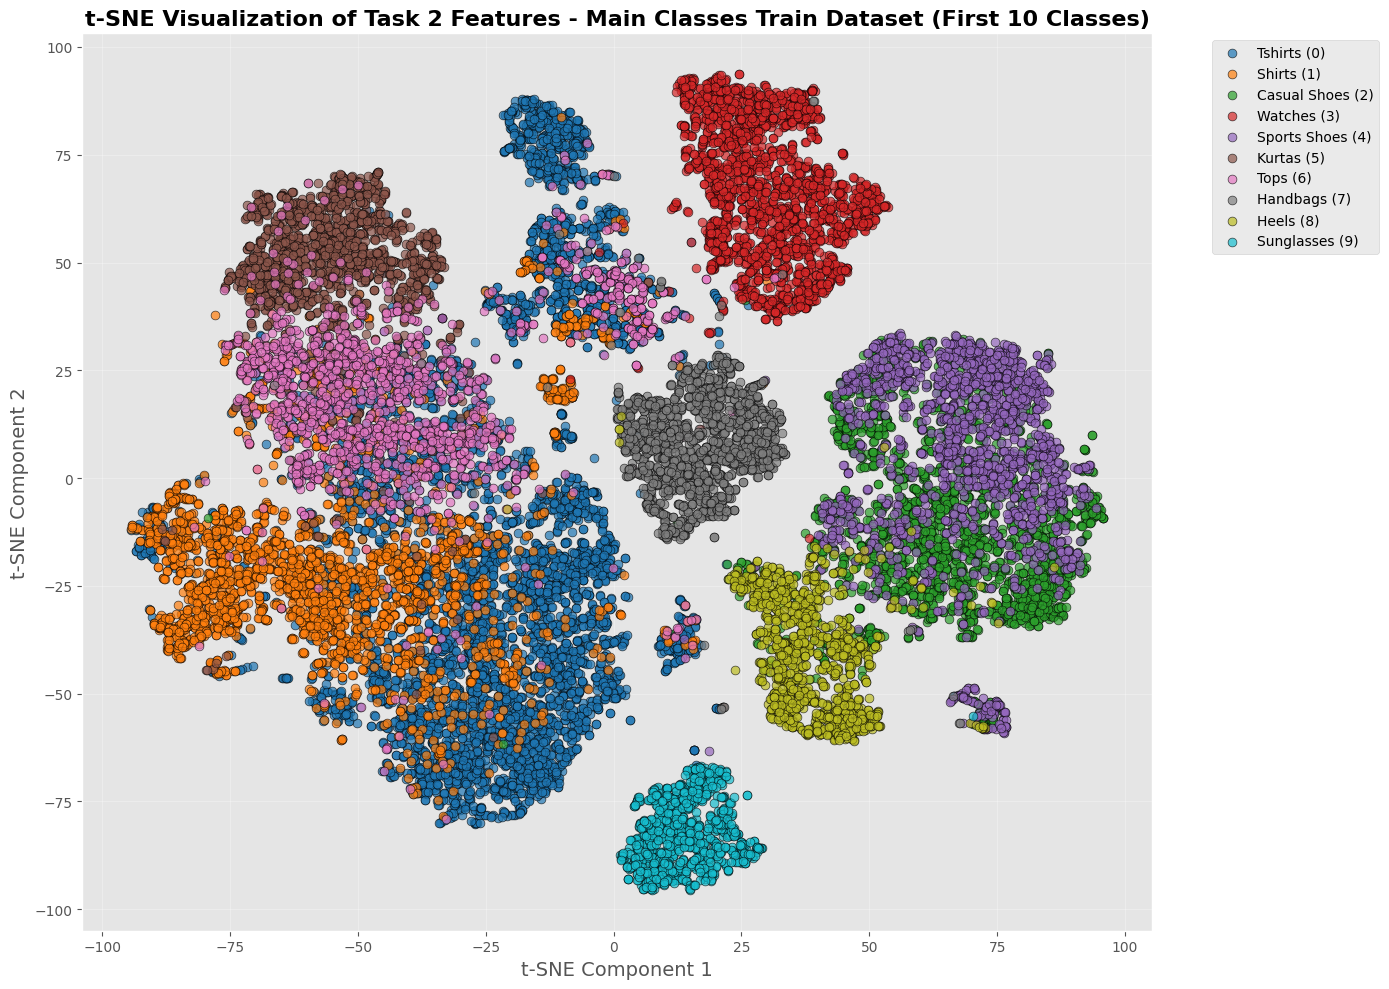


--- Test Dataset Visualization ---
Applying t-SNE to 1253 samples...


c:\Users\Andy\DP_assignment1\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


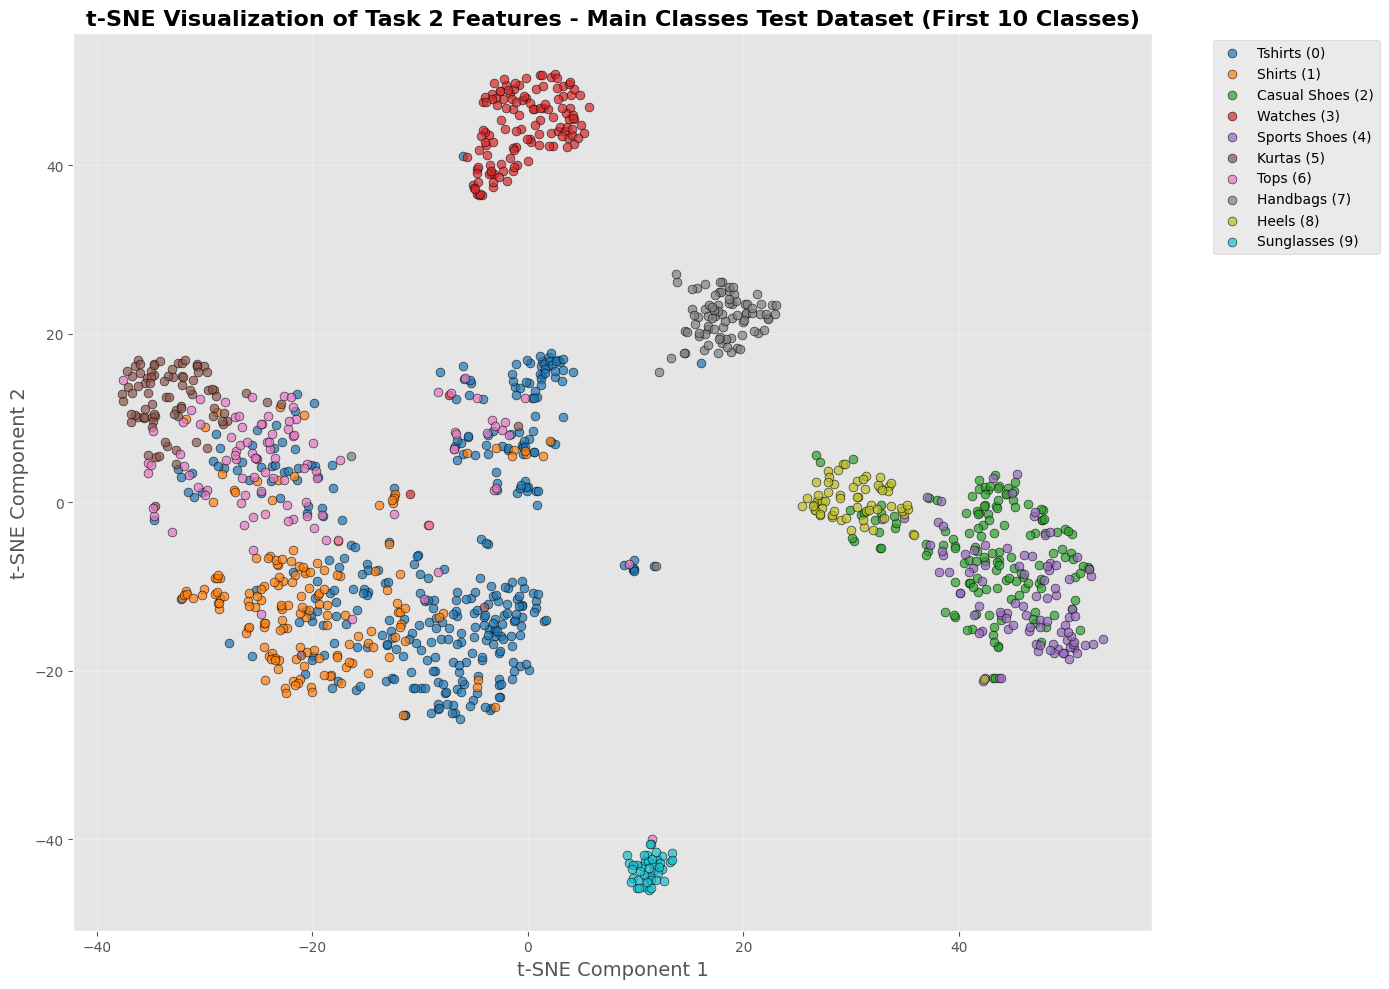

In [126]:
model_2 = FashionNetT2(embedding_dim=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2.load_state_dict(torch.load('task2_model.pth'))
model_2.to(device)

# Main execution for Task 4, Step 1
print("="*60)
print("TASK 4, STEP 1: VISUALIZING THE FEATURE LANDSCAPE")
print("="*60)

# Extract features from both datasets
print("\n1. Extracting features from training dataset (first 10 classes)...")
train_features, train_labels = extract_features_task4(model_2, train_first_10_loader, device)

print("\n2. Extracting features from test dataset (first 10 classes)...")
test_features, test_labels = extract_features_task4(model_2, main_test_first_10_loader, device)

print(f"\nDataset Information:")
print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Feature dimension: {train_features.shape[1]}")

# Generate scatter plots for both datasets
print("\n3. Generating t-SNE visualizations...")

print("\n--- Training Dataset Visualization ---")
train_tsne = apply_tsne_visualization(
    train_features, train_labels, label_id_to_label_name,
    'Main Classes Train Dataset (First 10 Classes)'
)

print("\n--- Test Dataset Visualization ---")
test_tsne = apply_tsne_visualization(
    test_features, test_labels, label_id_to_label_name,
    'Main Classes Test Dataset (First 10 Classes)'
)




=== SIDE-BY-SIDE COMPARISONS ===


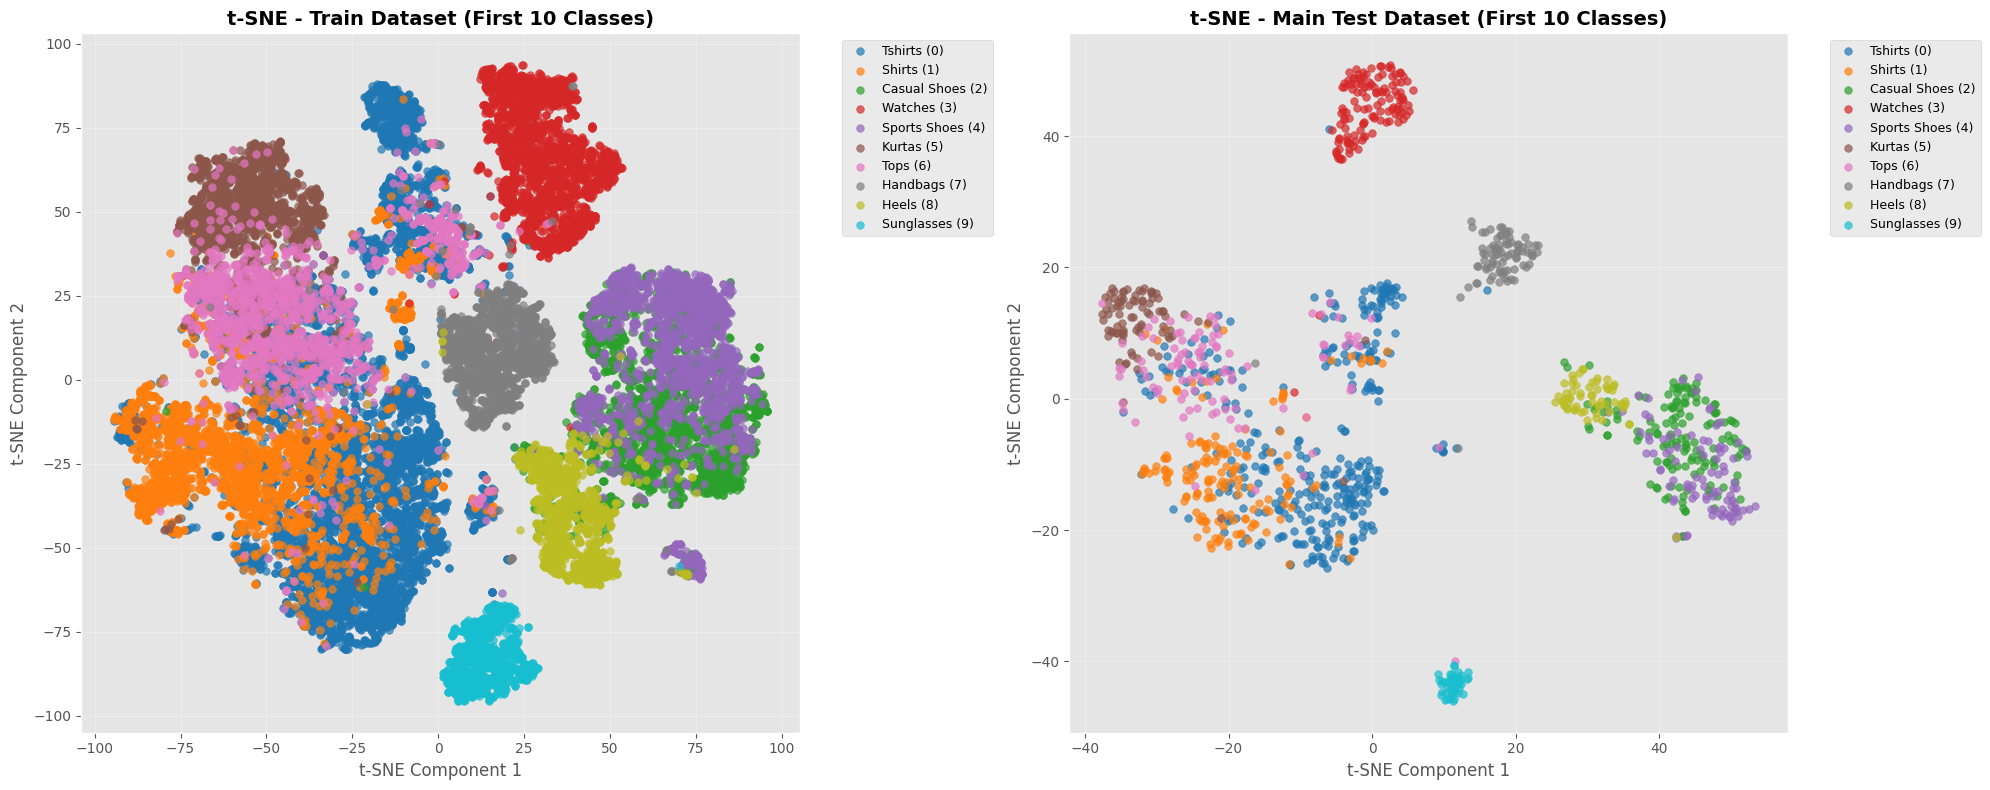

In [124]:
def create_comparison_plot_task4(train_reduced, train_labels, test_reduced, test_labels, method_name):
    """Create a comparison plot showing both train and test datasets side by side"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Get unique classes from both datasets - fix the concatenation
    all_classes = sorted(set(np.concatenate([train_labels, test_labels])))
    colors = plt.cm.tab10(range(len(all_classes)))
    
    # Plot train dataset
    for i, class_id in enumerate(all_classes):
        train_mask = train_labels == class_id
        if np.any(train_mask):
            class_name = label_id_to_label_name.get(class_id, f"Class {class_id}")
            ax1.scatter(train_reduced[train_mask, 0], train_reduced[train_mask, 1], 
                       c=[colors[i]], label=f"{class_name} ({class_id})", alpha=0.7, s=30)
    
    ax1.set_title(f'{method_name} - Train Dataset (First 10 Classes)', fontsize=14, fontweight='bold')
    ax1.set_xlabel(f'{method_name} Component 1', fontsize=12)
    ax1.set_ylabel(f'{method_name} Component 2', fontsize=12)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Plot test dataset
    for i, class_id in enumerate(all_classes):
        test_mask = test_labels == class_id
        if np.any(test_mask):
            class_name = label_id_to_label_name.get(class_id, f"Class {class_id}")
            ax2.scatter(test_reduced[test_mask, 0], test_reduced[test_mask, 1], 
                       c=[colors[i]], label=f"{class_name} ({class_id})", alpha=0.7, s=30)
    
    ax2.set_title(f'{method_name} - Main Test Dataset (First 10 Classes)', fontsize=14, fontweight='bold')
    ax2.set_xlabel(f'{method_name} Component 1', fontsize=12)
    ax2.set_ylabel(f'{method_name} Component 2', fontsize=12)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('t-SNE_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create comparison plots
print("\n=== SIDE-BY-SIDE COMPARISONS ===")
create_comparison_plot_task4(train_tsne, train_labels, test_tsne, test_labels, "t-SNE")


In [50]:
def analyze_cluster_separation_task4(features, labels, method_name):
    """Analyze which classes form distinct clusters and which overlap"""
    print(f"\n=== QUANTITATIVE ANALYSIS: {method_name} ===")
    
    # Calculate within-class and between-class distances
    distances = pairwise_distances(features)
    
    within_class_distances = []
    between_class_distances = []
    
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            if labels[i] == labels[j]:
                within_class_distances.append(distances[i, j])
            else:
                between_class_distances.append(distances[i, j])
    
    if within_class_distances and between_class_distances:
        avg_within = np.mean(within_class_distances)
        avg_between = np.mean(between_class_distances)
        
        print(f"Average within-class distance: {avg_within:.4f}")
        print(f"Average between-class distance: {avg_between:.4f}")
        print(f"Separation ratio (between/within): {avg_between/avg_within:.4f}")
        
        # Higher separation ratio = better clustering
        if avg_between/avg_within > 1.5:
            print("✓ Good class separation!")
        elif avg_between/avg_within > 1.2:
            print("Moderate class separation")
        else:
            print("Poor class separation")
    
    # Analyze per-class clustering
    print("\nPer-class compactness analysis:")
    unique_classes = sorted(set(labels))
    class_compactness = {}
    
    for class_id in unique_classes:
        class_mask = np.array(labels) == class_id
        class_count = np.sum(class_mask)
        
        if class_count > 1:
            class_features = features[class_mask]
            class_distances = pairwise_distances(class_features)
            avg_class_distance = np.mean(class_distances[class_distances > 0])
            class_compactness[class_id] = avg_class_distance
            
            class_name = label_id_to_label_name.get(class_id, f"Class {class_id}")
            print(f"  {class_name} ({class_id}): {class_count} samples, "
                  f"avg intra-class distance = {avg_class_distance:.4f}")
    
    return class_compactness

# Perform quantitative analysis
train_tsne_analysis = analyze_cluster_separation_task4(train_tsne, train_labels, "t-SNE (Train)")
test_tsne_analysis = analyze_cluster_separation_task4(test_tsne, test_labels, "t-SNE (Test)")



=== QUANTITATIVE ANALYSIS: t-SNE (Train) ===
Average within-class distance: 51.2481
Average between-class distance: 81.5037
Separation ratio (between/within): 1.5904
✓ Good class separation!

Per-class compactness analysis:
  Tshirts (0): 6339 samples, avg intra-class distance = 64.1139
  Shirts (1): 2906 samples, avg intra-class distance = 50.5961
  Casual Shoes (2): 2552 samples, avg intra-class distance = 33.2133
  Watches (3): 2282 samples, avg intra-class distance = 28.7916
  Sports Shoes (4): 1834 samples, avg intra-class distance = 38.6179
  Kurtas (5): 1661 samples, avg intra-class distance = 27.8748
  Tops (6): 1566 samples, avg intra-class distance = 44.9964
  Handbags (7): 1580 samples, avg intra-class distance = 22.6681
  Heels (8): 1212 samples, avg intra-class distance = 20.2188
  Sunglasses (9): 979 samples, avg intra-class distance = 11.5611

=== QUANTITATIVE ANALYSIS: t-SNE (Test) ===
Average within-class distance: 23.0991
Average between-class distance: 40.7057
Separ

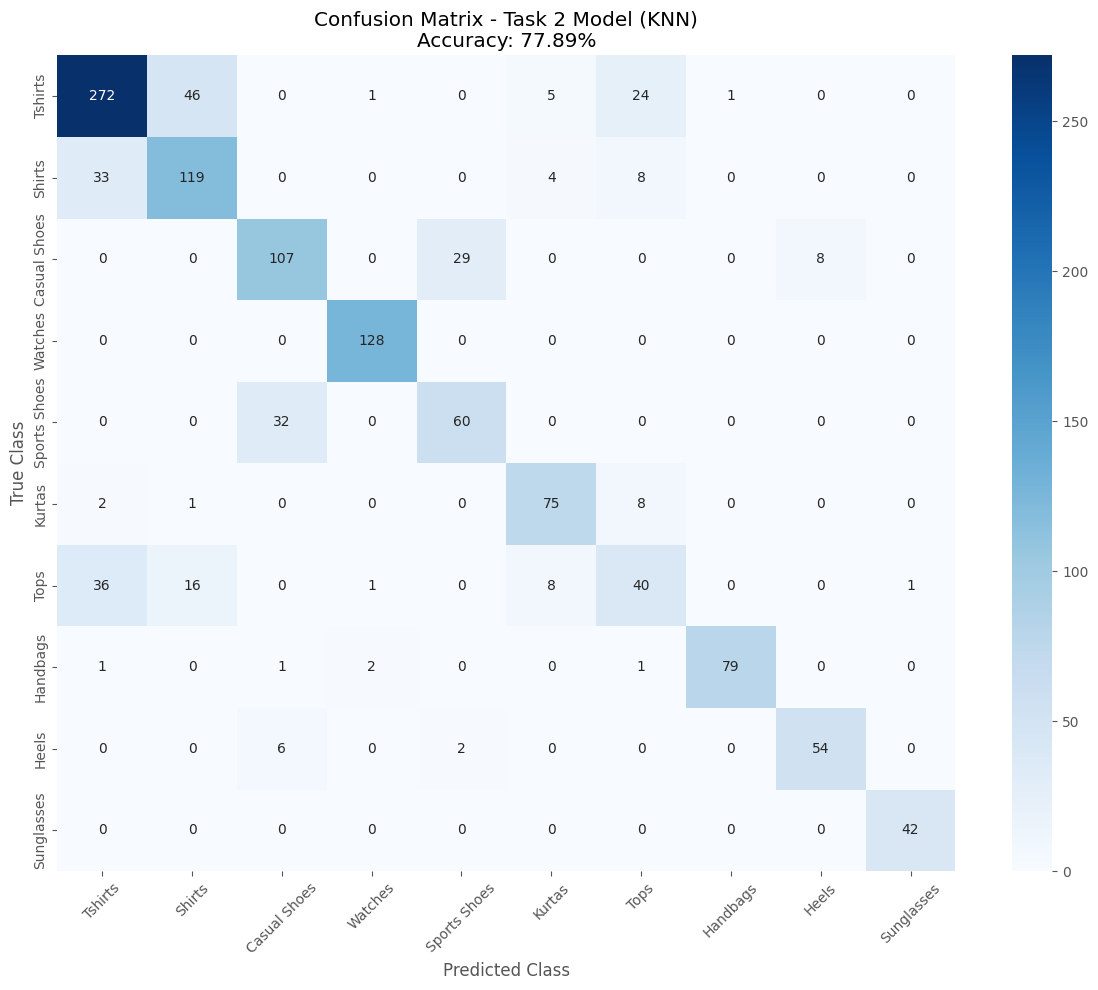

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def create_confusion_matrix_with_knn(model, support_loader, test_loader, device):
    """Create confusion matrix using embeddings"""
    
    # Extract features from support set
    model.eval()
    support_features = []
    support_labels = []
    
    with torch.no_grad():
        for inputs, labels in support_loader:
            inputs = inputs.to(device)
            features = model(inputs)  # Get embeddings
            support_features.append(features.cpu().numpy())
            support_labels.extend(labels.numpy())
    
    support_features = np.vstack(support_features)
    support_labels = np.array(support_labels)
    
    # Extract features from test set
    test_features = []
    test_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            features = model(inputs)  # Get embeddings
            test_features.append(features.cpu().numpy())
            test_labels.extend(labels.numpy())
    
    test_features = np.vstack(test_features)
    test_labels = np.array(test_labels)
    
    # Use KNN for classification
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
    knn.fit(support_features, support_labels)
    predictions = knn.predict(test_features)
    
    # Rest of confusion matrix code...
    accuracy = np.mean(predictions == test_labels) * 100
    
    # Create confusion matrix
    unique_classes = sorted(set(test_labels))
    cm = confusion_matrix(test_labels, predictions, labels=unique_classes)
    
    # Plot...
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[label_id_to_label_name.get(c, f"Class {c}") for c in unique_classes],
                yticklabels=[label_id_to_label_name.get(c, f"Class {c}") for c in unique_classes])
    
    plt.title(f'Confusion Matrix - Task 2 Model\nAccuracy: {accuracy:.2f}%')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return cm, accuracy

# Use this instead
cm, accuracy = create_confusion_matrix_with_knn(model_2, main_support_first_10_loader, main_test_first_10_loader, device)

In [54]:
# Step3
def extract_shirts_tshirts_data(dataset, features, labels, dataset_name=""):
    """Extract data specifically for shirts and T-shirts using correct identification"""
    
    print(f"\n=== EXTRACTING SHIRTS AND T-SHIRTS FROM {dataset_name} ===")
    
    # First, let's see what we actually have in the first 10 classes
    unique_labels = sorted(set(labels))
    print(f"Available labels in filtered dataset: {unique_labels}")
    
    # Check what each label corresponds to
    label_mapping = {}
    for label in unique_labels:
        # Find a sample with this label
        sample_indices = [i for i, l in enumerate(labels) if l == label]
        if sample_indices:
            # Get the first sample's index in the original dataset
            original_idx = sample_indices[0]  # This might need adjustment based on your filtering
            
            # We need to map back to the original dataset to get the article type name
            # This is tricky with the filtered dataset, so let's check the DataFrame directly
            try:
                # Find rows in the dataset with this articleTypeId
                matching_rows = dataset.df[dataset.df['articleTypeId'] == label]
                if len(matching_rows) > 0:
                    article_name = matching_rows.iloc[0]['articleTypeName']
                    label_mapping[label] = article_name
                    print(f"  Label {label}: {article_name} ({len(matching_rows)} total samples)")
            except:
                label_mapping[label] = f"Unknown_{label}"
                print(f"  Label {label}: Unknown")
    
    # Now identify shirts and T-shirts
    shirt_id = None
    tshirt_id = None
    
    for label, name in label_mapping.items():
        name_lower = name.lower()
        if 'tshirt' in name_lower or 't-shirt' in name_lower:
            tshirt_id = label
        elif 'shirt' in name_lower and 'tshirt' not in name_lower and 't-shirt' not in name_lower:
            shirt_id = label
    
    
    # Extract features and indices
    shirt_features = []
    shirt_indices = []
    tshirt_features = []
    tshirt_indices = []
    
    for i, label in enumerate(labels):
        if label == shirt_id:
            shirt_features.append(features[i])
            shirt_indices.append(i)
        elif label == tshirt_id:
            tshirt_features.append(features[i])
            tshirt_indices.append(i)
    
    shirt_features = np.array(shirt_features) if shirt_features else np.array([]).reshape(0, features.shape[1])
    tshirt_features = np.array(tshirt_features) if tshirt_features else np.array([]).reshape(0, features.shape[1])
    
    print(f"Final results:")
    print(f"  Shirts (ID {shirt_id}): {len(shirt_features)} samples")
    print(f"  T-shirts (ID {tshirt_id}): {len(tshirt_features)} samples")
    
    return {
        'shirt_id': shirt_id,
        'tshirt_id': tshirt_id,
        'shirt_features': shirt_features,
        'tshirt_features': tshirt_features,
        'shirt_indices': shirt_indices,
        'tshirt_indices': tshirt_indices,
        'label_mapping': label_mapping
    }

# Re-extract with proper identification
train_shirts_data_fixed = extract_shirts_tshirts_data(train_dataset, train_features, train_labels, "TRAIN")
test_shirts_data_fixed = extract_shirts_tshirts_data(main_test_dataset, test_features, test_labels, "TEST")


=== EXTRACTING SHIRTS AND T-SHIRTS FROM TRAIN ===
Available labels in filtered dataset: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
  Label 0: Tshirts (6339 total samples)
  Label 1: Shirts (2906 total samples)
  Label 2: Casual Shoes (2552 total samples)
  Label 3: Watches (2282 total samples)
  Label 4: Sports Shoes (1834 total samples)
  Label 5: Kurtas (1661 total samples)
  Label 6: Tops (1566 total samples)
  Label 7: Handbags (1580 total samples)
  Label 8: Heels (1212 total samples)
  Label 9: Sunglasses (979 total samples)
Final results:
  Shirts (ID 1): 2906 samples
  T-shirts (ID 0): 6339 samples

=== EXTRACTING SHIRTS AND T-SHIRTS FROM TEST ===
Available labels in filtered dataset: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
  Label 0: Tshirts (349 total samples)
  Label 1: Shirts (164 total samples)
 

In [55]:
def compute_centroids_and_typical_examples_fixed(train_data, test_data, train_dataset, train_first_10):
    """Compute centroids and find typical examples for shirts and T-shirts, with correct index mapping"""
    
    results = {}
    
    for item_type in ['shirt', 'tshirt']:
        print(f"\n--- Analyzing {item_type.upper()}S ---")
        
        train_features = train_data[f'{item_type}_features']
        test_features = test_data[f'{item_type}_features']
        train_indices = train_data[f'{item_type}_indices']
        
        if len(train_features) == 0:
            print(f"No {item_type} samples found in training data")
            continue
            
        # Compute centroids
        train_centroid = np.mean(train_features, axis=0)
        test_centroid = np.mean(test_features, axis=0) if len(test_features) > 0 else None
        
        print(f"Train centroid computed from {len(train_features)} samples")
        if test_centroid is not None:
            print(f"Test centroid computed from {len(test_features)} samples")
        
        # Find closest examples to train centroid
        distances_to_centroid = np.linalg.norm(train_features - train_centroid, axis=1)
        closest_idx = np.argmin(distances_to_centroid)
        
        # IMPORTANT: Map from filtered feature index to original dataset index
        # train_indices[closest_idx] gives us the index in the filtered dataset
        # We need to map this to the original dataset index
        filtered_dataset_idx = train_indices[closest_idx]
        
        # Get the original dataset index from the Subset
        original_dataset_idx = train_first_10.indices[filtered_dataset_idx]
        
        print(f"Most typical {item_type} (closest to centroid):")
        print(f"  Filtered dataset index: {filtered_dataset_idx}")
        print(f"  Original dataset index: {original_dataset_idx}")
        print(f"  Distance to centroid: {distances_to_centroid[closest_idx]:.4f}")
        
        # Get the imageId from the original dataset
        try:
            # Access the DataFrame using the original dataset index
            image_id = train_dataset.df.iloc[original_dataset_idx]['imageId']
            article_type_name = train_dataset.df.iloc[original_dataset_idx]['articleTypeName']
            article_type_id = train_dataset.df.iloc[original_dataset_idx]['articleTypeId']
            category_name = train_dataset.df.iloc[original_dataset_idx]['categoryName']
            
            print(f"  ImageId: {image_id}")
            print(f"  Article type: {article_type_name}")
            print(f"  Article type ID: {article_type_id}")
            print(f"  Category: {category_name}")
            
        except Exception as e:
            print(f"Error getting imageId: {e}")
            image_id = None
            article_type_name = "Unknown"
        
        # Find top 5 most typical examples
        sorted_indices = np.argsort(distances_to_centroid)
        top_examples = []
        top_image_ids = []
        top_original_indices = []
        
        print(f"\nTop 5 most typical {item_type}s:")
        print(f"{'Rank':<4} {'Filtered Idx':<12} {'Original Idx':<12} {'ImageId':<8} {'Distance':<10} {'Article Type'}")
        print("-" * 80)
        
        for rank, i in enumerate(sorted_indices[:5]):
            filtered_idx = train_indices[i]
            distance = distances_to_centroid[i]
            
            try:
                # Map to original dataset index
                original_idx = train_first_10.indices[filtered_idx]
                
                # Get image details
                image_id = train_dataset.df.iloc[original_idx]['imageId']
                article_type = train_dataset.df.iloc[original_idx]['articleTypeName']
                
                print(f"{rank+1:<4} {filtered_idx:<12} {original_idx:<12} {image_id:<8} {distance:<10.4f} {article_type}")
                
                top_examples.append(filtered_idx)
                top_original_indices.append(original_idx)
                top_image_ids.append(image_id)
                
            except Exception as e:
                print(f"{rank+1:<4} {filtered_idx:<12} ERROR       ERROR    {distance:<10.4f} Unknown")
                top_examples.append(filtered_idx)
                top_original_indices.append(None)
                top_image_ids.append(None)
        
        results[item_type] = {
            'train_centroid': train_centroid,
            'test_centroid': test_centroid,
            'typical_example_filtered_idx': filtered_dataset_idx,
            'typical_example_original_idx': original_dataset_idx,
            'typical_image_id': image_id if 'image_id' in locals() else None,
            'typical_distance': distances_to_centroid[closest_idx],
            'train_features': train_features,
            'test_features': test_features,
            'top_examples_filtered': top_examples,
            'top_examples_original': top_original_indices,
            'top_image_ids': top_image_ids,
            'all_distances': distances_to_centroid
        }
    
    return results

# Use the fixed function with proper index mapping
centroids_data_fixed = compute_centroids_and_typical_examples_fixed(
    train_shirts_data_fixed, test_shirts_data_fixed, train_dataset, train_first_10)


--- Analyzing SHIRTS ---
Train centroid computed from 2906 samples
Test centroid computed from 164 samples
Most typical shirt (closest to centroid):
  Filtered dataset index: 13152
  Original dataset index: 20632
  Distance to centroid: 0.0506
  ImageId: 13763
  Article type: Shirts
  Article type ID: 1
  Category: Topwear

Top 5 most typical shirts:
Rank Filtered Idx Original Idx ImageId  Distance   Article Type
--------------------------------------------------------------------------------
1    13152        20632        13763    0.0506     Shirts
2    17944        28160        19187    0.0549     Shirts
3    18824        29521        23034    0.0556     Shirts
4    12074        18946        13749    0.0558     Shirts
5    19968        31321        28806    0.0559     Shirts

--- Analyzing TSHIRTS ---
Train centroid computed from 6339 samples
Test centroid computed from 349 samples
Most typical tshirt (closest to centroid):
  Filtered dataset index: 12149
  Original dataset index: 1


=== VISUALIZING TYPICAL EXAMPLES ===


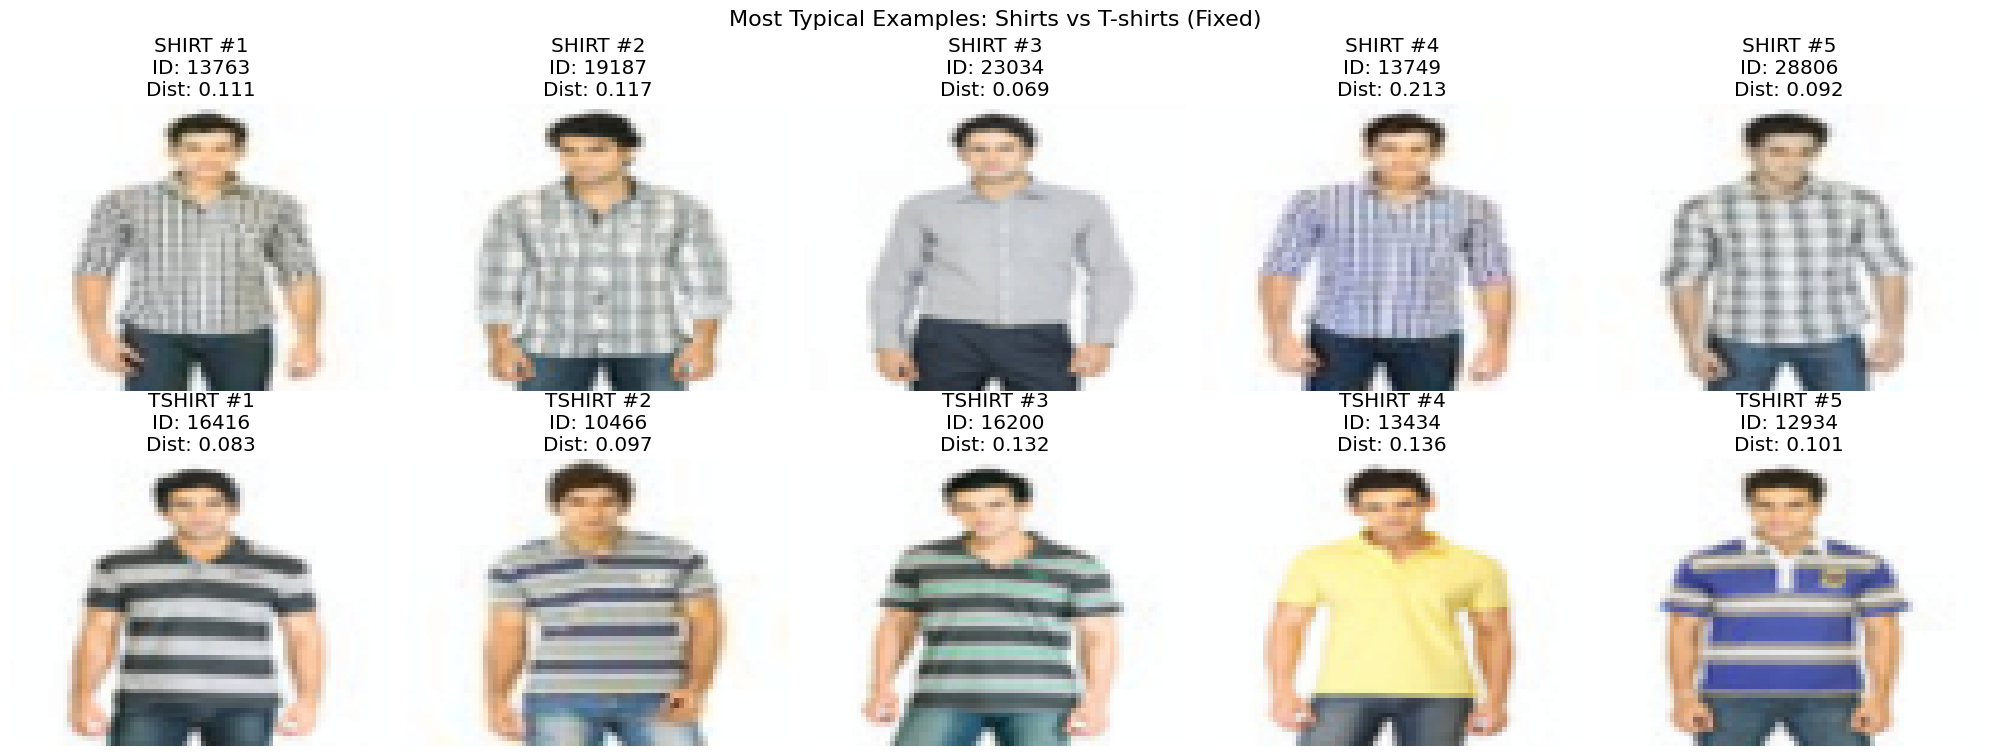

In [56]:
def visualize_typical_examples_fixed(centroids_data, train_dataset):
    """Visualize the most typical shirt and T-shirt examples"""
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    
    for row, (item_type, data) in enumerate(centroids_data.items()):
        if 'top_examples_original' not in data:
            continue
        
        # Show top 5 most typical examples using original indices
        top_original_indices = data['top_examples_original']
        top_image_ids = data['top_image_ids']
        distances = data['all_distances']
        
        for col in range(5):
            if col < len(top_original_indices) and top_original_indices[col] is not None:
                try:
                    original_idx = top_original_indices[col]
                    image_id = top_image_ids[col]
                    
                    # Load image from original dataset
                    image, label = train_dataset[original_idx]
                    
                    # Convert tensor to numpy for display
                    if torch.is_tensor(image):
                        # Denormalize the image
                        mean = np.array([0.485, 0.456, 0.406])
                        std = np.array([0.229, 0.224, 0.225])
                        image_np = image.permute(1, 2, 0).numpy()
                        image_np = image_np * std + mean
                        image_np = np.clip(image_np, 0, 1)
                    else:
                        image_np = np.array(image)
                    
                    axes[row, col].imshow(image_np)
                    
                    # Get distance for this example
                    distance = distances[col] if col < len(distances) else 0
                    
                    axes[row, col].set_title(f'{item_type.upper()} #{col+1}\nID: {image_id}\nDist: {distance:.3f}')
                    axes[row, col].axis('off')
                    
                except Exception as e:
                    print(f"Error displaying {item_type} example {col}: {e}")
                    axes[row, col].text(0.5, 0.5, f'Error loading\n{item_type} #{col+1}', 
                                      ha='center', va='center', transform=axes[row, col].transAxes)
                    axes[row, col].set_title(f'{item_type.upper()} #{col+1}')
                    axes[row, col].axis('off')
            else:
                axes[row, col].axis('off')
    
    plt.suptitle('Most Typical Examples: Shirts vs T-shirts (Fixed)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize the  results
print("\n=== VISUALIZING TYPICAL EXAMPLES ===")
visualize_typical_examples_fixed(centroids_data_fixed, train_dataset)

In [57]:
def analyze_shirt_tshirt_transition_fixed(centroids_data, train_features, train_labels, train_dataset, train_first_10):
    """Analyze the transition between shirts and T-shirts in feature space with correct index mapping"""
    
    if 'shirt' not in centroids_data or 'tshirt' not in centroids_data:
        print("Cannot analyze transition - missing shirt or T-shirt data")
        return None
    
    shirt_centroid = centroids_data['shirt']['train_centroid']
    tshirt_centroid = centroids_data['tshirt']['train_centroid']
    
    # Calculate distance between centroids
    centroid_distance = np.linalg.norm(shirt_centroid - tshirt_centroid)
    print(f"\nDistance between shirt and T-shirt centroids: {centroid_distance:.4f}")
    
    # Create line connecting the two centroids
    n_points = 10
    transition_points = []
    for i in range(n_points):
        alpha = i / (n_points - 1)
        point = (1 - alpha) * tshirt_centroid + alpha * shirt_centroid  # From T-shirt to shirt
        transition_points.append(point)
    
    transition_points = np.array(transition_points)
    
    # Find closest real samples to each transition point
    print(f"\n=== TRANSITION ANALYSIS: T-SHIRT → SHIRT ===")
    print("Finding samples closest to the line connecting T-shirt and shirt centroids...")
    
    closest_samples = []
    for i, transition_point in enumerate(transition_points):
        # Calculate distances to all training samples
        distances = np.linalg.norm(train_features - transition_point, axis=1)
        closest_feature_idx = np.argmin(distances)
        closest_distance = distances[closest_feature_idx]
        closest_label = train_labels[closest_feature_idx]
        
        # Map from feature index to original dataset index
        try:
            original_dataset_idx = train_first_10.indices[closest_feature_idx]
            
            # Get image details
            row = train_dataset.df.iloc[original_dataset_idx]
            image_id = row['imageId']
            article_type_name = row['articleTypeName']
            article_type_id = row['articleTypeId']
            
        except Exception as e:
            print(f"Error mapping index {closest_feature_idx}: {e}")
            original_dataset_idx = None
            image_id = None
            article_type_name = "Unknown"
            article_type_id = closest_label
        
        closest_samples.append({
            'transition_step': i,
            'alpha': i / (n_points - 1),
            'feature_idx': closest_feature_idx,
            'original_idx': original_dataset_idx,
            'distance': closest_distance,
            'label': closest_label,
            'image_id': image_id,
            'article_type_name': article_type_name,
            'article_type_id': article_type_id
        })
    
    # Display transition analysis
    print(f"\n{'Step':<4} {'Alpha':<6} {'Feature Idx':<11} {'Original Idx':<12} {'ImageId':<8} {'Distance':<10} {'Label':<6} {'Article Type'}")
    print("-" * 90)
    
    for sample in closest_samples:
        print(f"{sample['transition_step']:<4} {sample['alpha']:<6.2f} "
              f"{sample['feature_idx']:<11} {sample['original_idx'] or 'ERROR':<12} "
              f"{sample['image_id'] or 'ERROR':<8} {sample['distance']:<10.4f} "
              f"{sample['label']:<6} {sample['article_type_name']}")
    
    return closest_samples, transition_points

# Analyze transition with fixed index mapping
transition_data_fixed = analyze_shirt_tshirt_transition_fixed(
    centroids_data_fixed, train_features, train_labels, train_dataset, train_first_10)


Distance between shirt and T-shirt centroids: 0.0382

=== TRANSITION ANALYSIS: T-SHIRT → SHIRT ===
Finding samples closest to the line connecting T-shirt and shirt centroids...

Step Alpha  Feature Idx Original Idx ImageId  Distance   Label  Article Type
------------------------------------------------------------------------------------------
0    0.00   14378       22545        26516    0.0630     1      Shirts
1    0.11   14378       22545        26516    0.0616     1      Shirts
2    0.22   14378       22545        26516    0.0604     1      Shirts
3    0.33   14378       22545        26516    0.0596     1      Shirts
4    0.44   14378       22545        26516    0.0590     1      Shirts
5    0.56   13152       20632        13763    0.0580     1      Shirts
6    0.67   13152       20632        13763    0.0558     1      Shirts
7    0.78   13152       20632        13763    0.0538     1      Shirts
8    0.89   13152       20632        13763    0.0520     1      Shirts
9    1.00   13


=== VISUALIZING TRANSITION SAMPLES ===


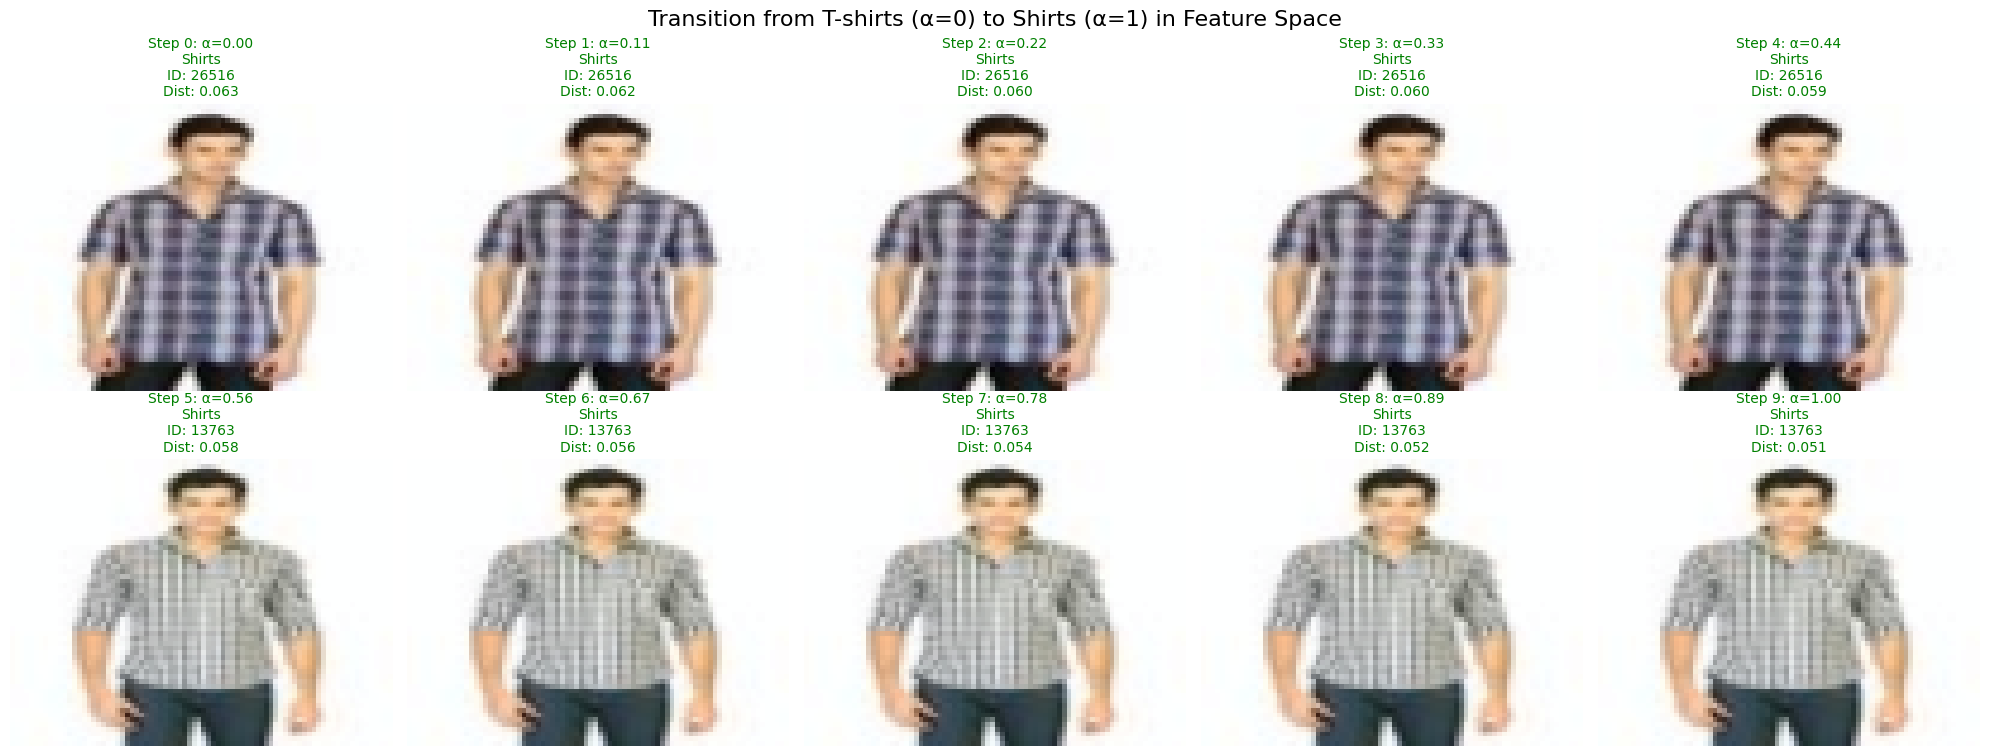

In [58]:
def visualize_transition_samples_fixed(transition_data, train_dataset, n_display=10):
    """Visualize samples along the shirt-T-shirt transition with correct indices"""
    
    if transition_data is None:
        print("No transition data available")
        return
    
    closest_samples, transition_points = transition_data
    
    # Use all samples or limit to n_display
    samples_to_show = closest_samples[:n_display]
    
    # Calculate grid size
    n_cols = 5
    n_rows = (len(samples_to_show) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, sample in enumerate(samples_to_show):
        row = i // n_cols
        col = i % n_cols
        
        if sample['original_idx'] is not None:
            try:
                # Load image from original dataset
                image, label = train_dataset[sample['original_idx']]
                
                # Convert tensor to numpy for display
                if torch.is_tensor(image):
                    # Denormalize the image
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    image_np = image.permute(1, 2, 0).numpy()
                    image_np = image_np * std + mean
                    image_np = np.clip(image_np, 0, 1)
                else:
                    image_np = np.array(image)
                
                axes[row, col].imshow(image_np)
                
                # Color code the title based on class
                if sample['label'] == centroids_data_fixed['tshirt']['typical_example_original_idx']:
                    title_color = 'blue'  # T-shirt color
                elif sample['label'] == centroids_data_fixed['shirt']['typical_example_original_idx']:
                    title_color = 'red'   # Shirt color
                else:
                    title_color = 'green' # Other classes
                
                title = (f"Step {sample['transition_step']}: α={sample['alpha']:.2f}\n"
                        f"{sample['article_type_name']}\n"
                        f"ID: {sample['image_id']}\n"
                        f"Dist: {sample['distance']:.3f}")
                
                axes[row, col].set_title(title, color=title_color, fontsize=10)
                axes[row, col].axis('off')
                
            except Exception as e:
                print(f"Error displaying transition sample {i}: {e}")
                axes[row, col].text(0.5, 0.5, f'Error loading\nStep {sample["transition_step"]}', 
                                  ha='center', va='center', transform=axes[row, col].transAxes)
                axes[row, col].set_title(f'Step {sample["transition_step"]}: α={sample["alpha"]:.2f}')
                axes[row, col].axis('off')
        else:
            axes[row, col].text(0.5, 0.5, f'Index Error\nStep {sample["transition_step"]}', 
                              ha='center', va='center', transform=axes[row, col].transAxes)
            axes[row, col].set_title(f'Step {sample["transition_step"]}: α={sample["alpha"]:.2f}')
            axes[row, col].axis('off')
    
    # Hide unused subplots
    for i in range(len(samples_to_show), n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].axis('off')
    
    plt.suptitle('Transition from T-shirts (α=0) to Shirts (α=1) in Feature Space', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize transition samples
if transition_data_fixed is not None:
    print("\n=== VISUALIZING TRANSITION SAMPLES ===")
    visualize_transition_samples_fixed(transition_data_fixed, train_dataset)

In [59]:
def analyze_transition_patterns(transition_data, centroids_data):
    """Analyze patterns in the transition between shirts and T-shirts"""
    
    if transition_data is None:
        print("No transition data available")
        return
    
    closest_samples, _ = transition_data
    
    print(f"\n{'='*60}")
    print("TRANSITION PATTERN ANALYSIS")
    print("="*60)
    
    # Count classes along the transition
    class_counts = {}
    for sample in closest_samples:
        class_name = sample['article_type_name']
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    
    print(f"\nClasses found along the transition:")
    for class_name, count in sorted(class_counts.items()):
        percentage = (count / len(closest_samples)) * 100
        print(f"  {class_name}: {count}/{len(closest_samples)} samples ({percentage:.1f}%)")
    
    # Analyze transition smoothness
    print(f"\nTransition smoothness analysis:")
    
    # Check if we have actual shirts and T-shirts in the transition
    shirt_steps = [s for s in closest_samples if 'shirt' in s['article_type_name'].lower() and 'tshirt' not in s['article_type_name'].lower()]
    tshirt_steps = [s for s in closest_samples if 'tshirt' in s['article_type_name'].lower()]
    
    print(f"  T-shirt samples in transition: {len(tshirt_steps)}")
    print(f"  Shirt samples in transition: {len(shirt_steps)}")
    
    if tshirt_steps:
        tshirt_alphas = [s['alpha'] for s in tshirt_steps]
        print(f"  T-shirts appear at α values: {tshirt_alphas}")
    
    if shirt_steps:
        shirt_alphas = [s['alpha'] for s in shirt_steps]
        print(f"  Shirts appear at α values: {shirt_alphas}")
    
    # Check for intermediate classes
    other_classes = [s for s in closest_samples if 'shirt' not in s['article_type_name'].lower()]
    if other_classes:
        print(f"\nIntermediate classes (not shirts/T-shirts):")
        for sample in other_classes:
            print(f"  Step {sample['transition_step']} (α={sample['alpha']:.2f}): {sample['article_type_name']}")
    
    # Distance analysis
    distances = [s['distance'] for s in closest_samples]
    print(f"\nDistance to transition line:")
    print(f"  Average distance: {np.mean(distances):.4f}")
    print(f"  Min distance: {np.min(distances):.4f}")
    print(f"  Max distance: {np.max(distances):.4f}")
    print(f"  Std deviation: {np.std(distances):.4f}")
    
    # Interpretation
    print(f"\n{'='*40}")
    print("INTERPRETATION")
    print("="*40)
    
    if len(set(class_counts.keys())) <= 2:
        print("✓ Clean transition - only shirts and T-shirts found")
    elif len(set(class_counts.keys())) <= 4:
        print("~ Moderate transition - few intermediate classes")
    else:
        print("⚠ Complex transition - many different classes involved")
    
    avg_distance = np.mean(distances)
    if avg_distance < 1.0:
        print("✓ Tight transition - samples are close to the connecting line")
    elif avg_distance < 2.0:
        print("~ Moderate transition - reasonable proximity to connecting line")
    else:
        print("⚠ Loose transition - samples are far from the connecting line")
    
    return class_counts, distances

# Analyze transition patterns
if transition_data_fixed is not None:
    transition_analysis = analyze_transition_patterns(transition_data_fixed, centroids_data_fixed)


TRANSITION PATTERN ANALYSIS

Classes found along the transition:
  Shirts: 10/10 samples (100.0%)

Transition smoothness analysis:
  T-shirt samples in transition: 0
  Shirt samples in transition: 10
  Shirts appear at α values: [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777778, 0.8888888888888888, 1.0]

Distance to transition line:
  Average distance: 0.0574
  Min distance: 0.0506
  Max distance: 0.0630
  Std deviation: 0.0040

INTERPRETATION
✓ Clean transition - only shirts and T-shirts found
✓ Tight transition - samples are close to the connecting line



=== VISUALIZING CENTROID LINE AND TRANSITION SAMPLES ===
Creating visualization of centroid line and transition samples...
Applying t-SNE for visualization...


c:\Users\Andy\DP_assignment1\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


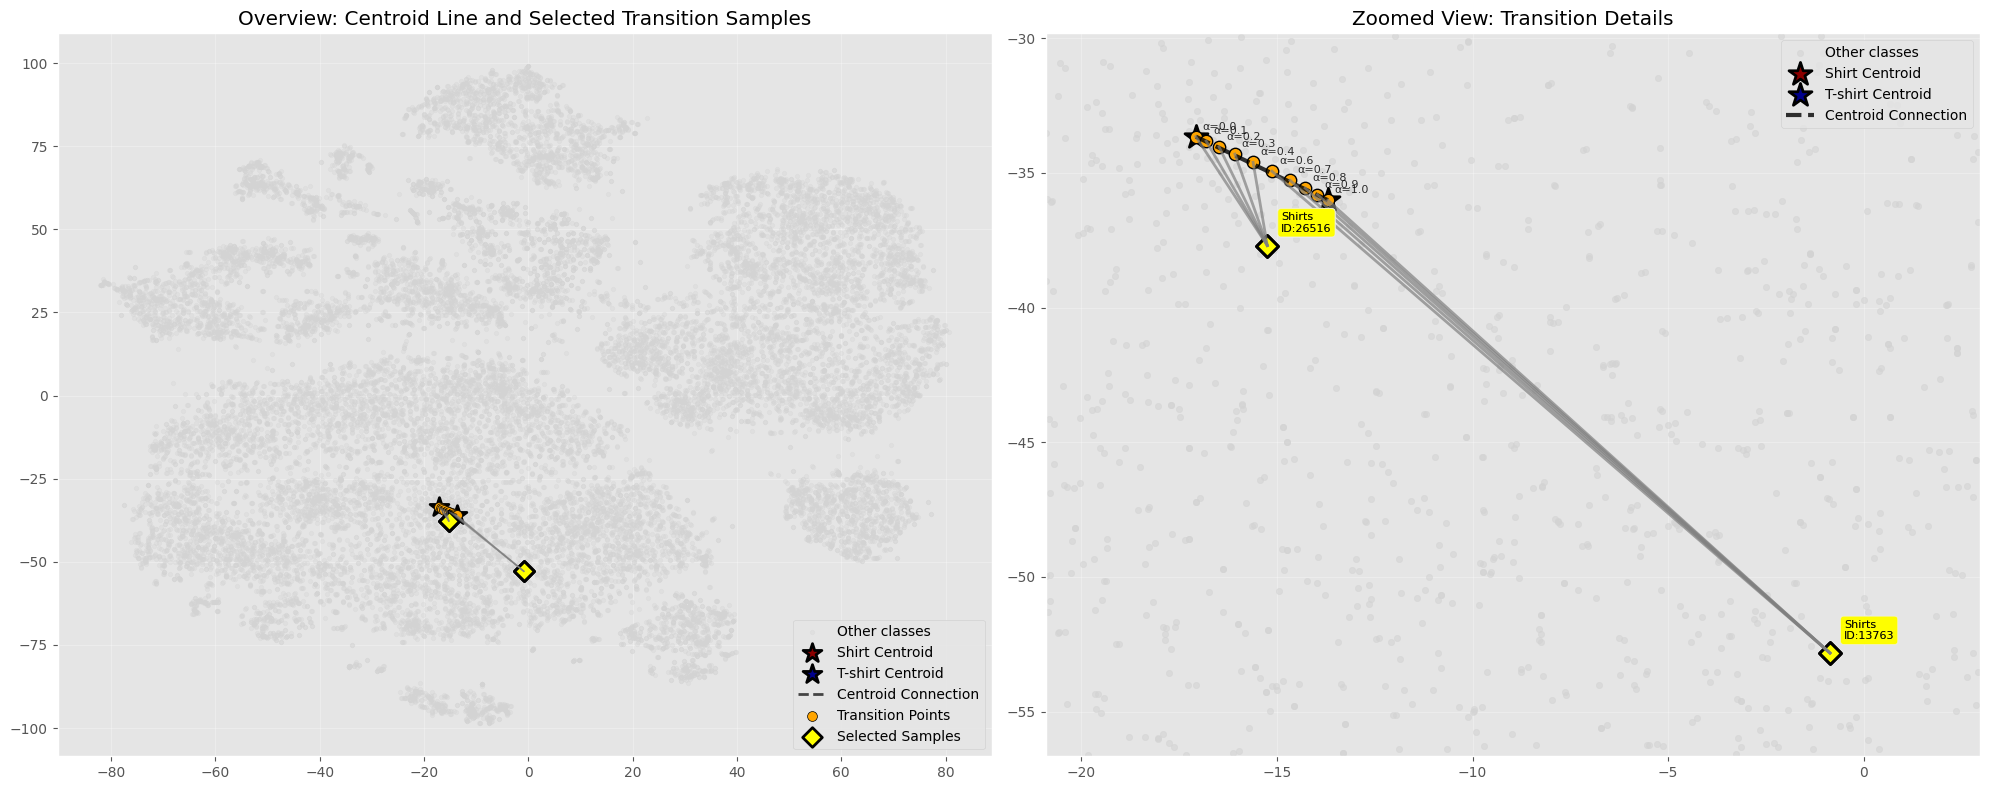


VISUALIZATION SUMMARY
• Total transition points: 10
• Selected samples: 10
• Average distance from transition line: 0.0574

Selected samples along the transition:
  Step 0 (α=0.00): Shirts (ID: 26516)
  Step 1 (α=0.11): Shirts (ID: 26516)
  Step 2 (α=0.22): Shirts (ID: 26516)
  Step 3 (α=0.33): Shirts (ID: 26516)
  Step 4 (α=0.44): Shirts (ID: 26516)
  Step 5 (α=0.56): Shirts (ID: 13763)
  Step 6 (α=0.67): Shirts (ID: 13763)
  Step 7 (α=0.78): Shirts (ID: 13763)
  Step 8 (α=0.89): Shirts (ID: 13763)
  Step 9 (α=1.00): Shirts (ID: 13763)


In [60]:
def visualize_centroid_line_and_samples(centroids_data, transition_data, train_features, train_labels, train_dataset, train_first_10):
    """Visualize the line connecting centroids and the selected transition samples"""
    
    if transition_data is None or 'shirt' not in centroids_data or 'tshirt' not in centroids_data:
        print("Missing required data for visualization")
        return
    
    closest_samples, transition_points = transition_data
    shirt_centroid = centroids_data['shirt']['train_centroid']
    tshirt_centroid = centroids_data['tshirt']['train_centroid']
    
    print("Creating visualization of centroid line and transition samples...")
    
    # Combine all relevant points for dimensionality reduction
    all_points = []
    point_labels = []
    point_types = []
    point_info = []
    
    # Add all training features
    for i, feature in enumerate(train_features):
        all_points.append(feature)
        point_labels.append(train_labels[i])
        point_types.append('training')
        point_info.append({'type': 'training', 'index': i})
    
    # Add centroids
    all_points.append(shirt_centroid)
    point_labels.append(-1)  # Special label for centroid
    point_types.append('shirt_centroid')
    point_info.append({'type': 'shirt_centroid'})
    
    all_points.append(tshirt_centroid)
    point_labels.append(-2)  # Special label for centroid
    point_types.append('tshirt_centroid')
    point_info.append({'type': 'tshirt_centroid'})
    
    # Add transition points
    for i, point in enumerate(transition_points):
        all_points.append(point)
        point_labels.append(-3)  # Special label for transition points
        point_types.append('transition')
        point_info.append({'type': 'transition', 'step': i, 'alpha': i/(len(transition_points)-1)})
    
    # Add selected samples (the actual samples closest to transition points)
    selected_indices = []
    for sample in closest_samples:
        feature_idx = sample['feature_idx']
        selected_indices.append(feature_idx)
        # Mark these points specially
        point_info[feature_idx]['selected'] = True
        point_info[feature_idx]['transition_step'] = sample['transition_step']
        point_info[feature_idx]['alpha'] = sample['alpha']
    
    all_points = np.array(all_points)
    
    # Apply dimensionality reduction
    print("Applying t-SNE for visualization...")
    from sklearn.manifold import TSNE
    
    # Use a smaller perplexity for better local structure
    perplexity = min(30, len(all_points) // 4)
    perplexity = max(5, perplexity)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=1000)
    reduced_points = tsne.fit_transform(all_points)
    
    # Separate the reduced points
    n_training = len(train_features)
    training_reduced = reduced_points[:n_training]
    shirt_centroid_reduced = reduced_points[n_training]
    tshirt_centroid_reduced = reduced_points[n_training + 1]
    transition_points_reduced = reduced_points[n_training + 2:n_training + 2 + len(transition_points)]
    
    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Overview with all points
    # Plot training samples
    shirt_mask = np.array(train_labels) == centroids_data['shirt']['shirt_id'] if 'shirt_id' in centroids_data['shirt'] else []
    tshirt_mask = np.array(train_labels) == centroids_data['tshirt']['tshirt_id'] if 'tshirt_id' in centroids_data['tshirt'] else []
    other_mask = ~(shirt_mask | tshirt_mask) if len(shirt_mask) > 0 and len(tshirt_mask) > 0 else np.ones(len(train_labels), dtype=bool)
    
    # Plot different classes
    if len(shirt_mask) > 0 and np.any(shirt_mask):
        ax1.scatter(training_reduced[shirt_mask, 0], training_reduced[shirt_mask, 1], 
                   c='red', alpha=0.6, s=20, label='Shirts')
    
    if len(tshirt_mask) > 0 and np.any(tshirt_mask):
        ax1.scatter(training_reduced[tshirt_mask, 0], training_reduced[tshirt_mask, 1], 
                   c='blue', alpha=0.6, s=20, label='T-shirts')
    
    if np.any(other_mask):
        ax1.scatter(training_reduced[other_mask, 0], training_reduced[other_mask, 1], 
                   c='lightgray', alpha=0.3, s=10, label='Other classes')
    
    # Plot centroids
    ax1.scatter(shirt_centroid_reduced[0], shirt_centroid_reduced[1], 
               c='darkred', s=200, marker='*', label='Shirt Centroid', edgecolors='black', linewidth=2)
    ax1.scatter(tshirt_centroid_reduced[0], tshirt_centroid_reduced[1], 
               c='darkblue', s=200, marker='*', label='T-shirt Centroid', edgecolors='black', linewidth=2)
    
    # Draw line connecting centroids
    ax1.plot([tshirt_centroid_reduced[0], shirt_centroid_reduced[0]], 
             [tshirt_centroid_reduced[1], shirt_centroid_reduced[1]], 
             'k--', linewidth=2, alpha=0.7, label='Centroid Connection')
    
    # Plot transition points
    ax1.scatter(transition_points_reduced[:, 0], transition_points_reduced[:, 1], 
               c='orange', s=50, marker='o', label='Transition Points', edgecolors='black')
    
    # Plot selected samples
    selected_reduced = training_reduced[selected_indices]
    ax1.scatter(selected_reduced[:, 0], selected_reduced[:, 1], 
               c='yellow', s=100, marker='D', label='Selected Samples', edgecolors='black', linewidth=2)
    
    # Connect transition points to selected samples
    for i, sample in enumerate(closest_samples):
        feature_idx = sample['feature_idx']
        if feature_idx < len(training_reduced):
            ax1.plot([transition_points_reduced[i, 0], training_reduced[feature_idx, 0]], 
                     [transition_points_reduced[i, 1], training_reduced[feature_idx, 1]], 
                     'gray', alpha=0.5, linewidth=1)
    
    ax1.set_title('Overview: Centroid Line and Selected Transition Samples')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Zoomed view focusing on the transition area
    # Calculate bounds around the transition area
    all_transition_x = np.concatenate([transition_points_reduced[:, 0], selected_reduced[:, 0], 
                                      [shirt_centroid_reduced[0], tshirt_centroid_reduced[0]]])
    all_transition_y = np.concatenate([transition_points_reduced[:, 1], selected_reduced[:, 1], 
                                      [shirt_centroid_reduced[1], tshirt_centroid_reduced[1]]])
    
    margin = 0.2 * max(np.ptp(all_transition_x), np.ptp(all_transition_y))
    x_min, x_max = np.min(all_transition_x) - margin, np.max(all_transition_x) + margin
    y_min, y_max = np.min(all_transition_y) - margin, np.max(all_transition_y) + margin
    
    # Plot only points in the transition area
    in_area = ((training_reduced[:, 0] >= x_min) & (training_reduced[:, 0] <= x_max) & 
               (training_reduced[:, 1] >= y_min) & (training_reduced[:, 1] <= y_max))
    
    if len(shirt_mask) > 0:
        shirt_in_area = shirt_mask & in_area
        if np.any(shirt_in_area):
            ax2.scatter(training_reduced[shirt_in_area, 0], training_reduced[shirt_in_area, 1], 
                       c='red', alpha=0.8, s=30, label='Shirts')
    
    if len(tshirt_mask) > 0:
        tshirt_in_area = tshirt_mask & in_area
        if np.any(tshirt_in_area):
            ax2.scatter(training_reduced[tshirt_in_area, 0], training_reduced[tshirt_in_area, 1], 
                       c='blue', alpha=0.8, s=30, label='T-shirts')
    
    other_in_area = other_mask & in_area
    if np.any(other_in_area):
        ax2.scatter(training_reduced[other_in_area, 0], training_reduced[other_in_area, 1], 
                   c='lightgray', alpha=0.6, s=20, label='Other classes')
    
    # Plot centroids
    ax2.scatter(shirt_centroid_reduced[0], shirt_centroid_reduced[1], 
               c='darkred', s=300, marker='*', label='Shirt Centroid', edgecolors='black', linewidth=2)
    ax2.scatter(tshirt_centroid_reduced[0], tshirt_centroid_reduced[1], 
               c='darkblue', s=300, marker='*', label='T-shirt Centroid', edgecolors='black', linewidth=2)
    
    # Draw line connecting centroids
    ax2.plot([tshirt_centroid_reduced[0], shirt_centroid_reduced[0]], 
             [tshirt_centroid_reduced[1], shirt_centroid_reduced[1]], 
             'k--', linewidth=3, alpha=0.8, label='Centroid Connection')
    
    # Plot transition points with labels
    for i, point in enumerate(transition_points_reduced):
        alpha = i / (len(transition_points_reduced) - 1)
        ax2.scatter(point[0], point[1], c='orange', s=80, marker='o', 
                   edgecolors='black', linewidth=1)
        ax2.annotate(f'α={alpha:.1f}', (point[0], point[1]), xytext=(5, 5), 
                    textcoords='offset points', fontsize=8, alpha=0.8)
    
    # Plot selected samples with labels
    for i, sample in enumerate(closest_samples):
        feature_idx = sample['feature_idx']
        if feature_idx < len(training_reduced):
            point = training_reduced[feature_idx]
            ax2.scatter(point[0], point[1], c='yellow', s=120, marker='D', 
                       edgecolors='black', linewidth=2)
            
            # Add connection line
            ax2.plot([transition_points_reduced[i, 0], point[0]], 
                     [transition_points_reduced[i, 1], point[1]], 
                     'gray', alpha=0.7, linewidth=2)
            
            # Add label with article type
            label_text = f"{sample['article_type_name'][:8]}\nID:{sample['image_id']}"
            ax2.annotate(label_text, (point[0], point[1]), xytext=(10, 10), 
                        textcoords='offset points', fontsize=8, 
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)
    ax2.set_title('Zoomed View: Transition Details')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'='*60}")
    print("VISUALIZATION SUMMARY")
    print("="*60)
    print(f"• Total transition points: {len(transition_points)}")
    print(f"• Selected samples: {len(closest_samples)}")
    print(f"• Average distance from transition line: {np.mean([s['distance'] for s in closest_samples]):.4f}")
    
    # Show which samples were selected
    print(f"\nSelected samples along the transition:")
    for sample in closest_samples:
        print(f"  Step {sample['transition_step']} (α={sample['alpha']:.2f}): "
              f"{sample['article_type_name']} (ID: {sample['image_id']})")

# Create the visualization
if transition_data_fixed is not None and centroids_data_fixed is not None:
    print("\n=== VISUALIZING CENTROID LINE AND TRANSITION SAMPLES ===")
    visualize_centroid_line_and_samples(
        centroids_data_fixed, transition_data_fixed, train_features, train_labels, 
        train_dataset, train_first_10)

In [64]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import defaultdict

def create_article_to_category_mapping(dataset):
    """Create mapping from articleTypeId to categoryId using the dataset"""
    df = dataset.df
    mapping_df = df[['articleTypeId', 'categoryId', 'articleTypeName', 'categoryName']].drop_duplicates()
    mapping_df = mapping_df.sort_values('articleTypeId')
    
    # Create the mapping dictionary
    article_to_category = {}
    category_names = {}
    article_names = {}
    
    for _, row in mapping_df.iterrows():
        article_id = int(row['articleTypeId'])
        category_id = int(row['categoryId'])
        article_to_category[article_id] = category_id
        category_names[category_id] = row['categoryName']
        article_names[article_id] = row['articleTypeName']
    
    print("\nArticle Type to Category Mapping:")
    print("=" * 60)
    for article_id in sorted(article_to_category.keys()):
        category_id = article_to_category[article_id]
        print(f"Article {article_id:2d} ({article_names[article_id]:15s}) -> Category {category_id:2d} ({category_names[category_id]})")
    
    print(f"\nTotal Article Types: {len(article_to_category)}")
    print(f"Total Categories: {len(set(article_to_category.values()))}")
    
    return article_to_category, category_names, article_names

def extract_features(model, dataloader, device):
    """Extract features using the trained Task 2 model"""
    model.eval()
    features = []
    article_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)  # Get embeddings
            features.append(outputs.cpu().numpy())
            article_labels.extend(labels.numpy())
    
    features = np.vstack(features)
    article_labels = np.array(article_labels)
    
    return features, article_labels

def convert_to_category_labels(article_labels, article_to_category):
    """Convert article type labels to category labels"""
    return np.array([article_to_category[art_id] for art_id in article_labels])

def evaluate_hierarchical_classification(train_features, train_labels, test_features, test_labels, 
                                      category_names, k=1):
    """Evaluate classification performance using k-NN"""
    from sklearn.neighbors import KNeighborsClassifier
    
    # Train k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(train_features, train_labels)
    
    # Predict on test set
    predictions = knn.predict(test_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    
    # Generate detailed report
    report = classification_report(test_labels, predictions, 
                                 target_names=[category_names[i] for i in sorted(set(test_labels))],
                                 digits=3)
    
    print(f"\nClassification Accuracy: {accuracy:.3f}")
    print("\nDetailed Classification Report:")
    print(report)
    
    return predictions, accuracy

def visualize_confusion_matrix(true_labels, predictions, category_names):
    """Create and display confusion matrix"""
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[category_names[i] for i in sorted(set(true_labels))],
                yticklabels=[category_names[i] for i in sorted(set(true_labels))])
    plt.title('Confusion Matrix - Category Classification')
    plt.xlabel('Predicted Category')
    plt.ylabel('True Category')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def compare_hierarchical_performance(model, train_loader, test_loader, article_to_category, 
                                   category_names, device):
    """Compare performance between article-level and category-level classification"""
    # Extract features
    print("Extracting features...")
    train_features, train_article_labels = extract_features(model, train_loader, device)
    test_features, test_article_labels = extract_features(model, test_loader, device)
    
    # Convert to category labels
    train_category_labels = convert_to_category_labels(train_article_labels, article_to_category)
    test_category_labels = convert_to_category_labels(test_article_labels, article_to_category)
    
    # Evaluate article-level classification
    print("\nEvaluating article-level classification (39 classes)...")
    article_predictions, article_accuracy = evaluate_hierarchical_classification(
        train_features, train_article_labels, test_features, test_article_labels, 
        {i: f"Article_{i}" for i in range(39)})
    
    # Evaluate category-level classification
    print("\nEvaluating category-level classification (20 classes)...")
    category_predictions, category_accuracy = evaluate_hierarchical_classification(
        train_features, train_category_labels, test_features, test_category_labels, 
        category_names)
    
    # Visualize confusion matrix for categories
    visualize_confusion_matrix(test_category_labels, category_predictions, category_names)
    
    # Compare performances
    print("\nPerformance Comparison:")
    print(f"Article-level accuracy: {article_accuracy:.3f}")
    print(f"Category-level accuracy: {category_accuracy:.3f}")
    print(f"Difference (Category - Article): {category_accuracy - article_accuracy:.3f}")




C:\Users\Andy\AppData\Local\Temp\ipykernel_21800\946073485.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('task2_model.pth'))



Article Type to Category Mapping:
Article  0 (Tshirts        ) -> Category  0 (Topwear)
Article  1 (Shirts         ) -> Category  0 (Topwear)
Article  2 (Casual Shoes   ) -> Category  1 (Shoes)
Article  3 (Watches        ) -> Category  3 (Watches)
Article  4 (Sports Shoes   ) -> Category  1 (Shoes)
Article  5 (Kurtas         ) -> Category  0 (Topwear)
Article  6 (Tops           ) -> Category  0 (Topwear)
Article  7 (Handbags       ) -> Category  2 (Bags)
Article  8 (Heels          ) -> Category  1 (Shoes)
Article  9 (Sunglasses     ) -> Category  7 (Eyewear)
Article 10 (Wallets        ) -> Category  2 (Bags)
Article 11 (Flip Flops     ) -> Category 11 (Flip Flops)
Article 12 (Sandals        ) -> Category  1 (Shoes)
Article 13 (Briefs         ) -> Category  5 (Innerwear)
Article 14 (Belts          ) -> Category 12 (Belts)
Article 15 (Backpacks      ) -> Category  2 (Bags)
Article 16 (Socks          ) -> Category 13 (Socks)
Article 17 (Formal Shoes   ) -> Category  1 (Shoes)
Article 18 

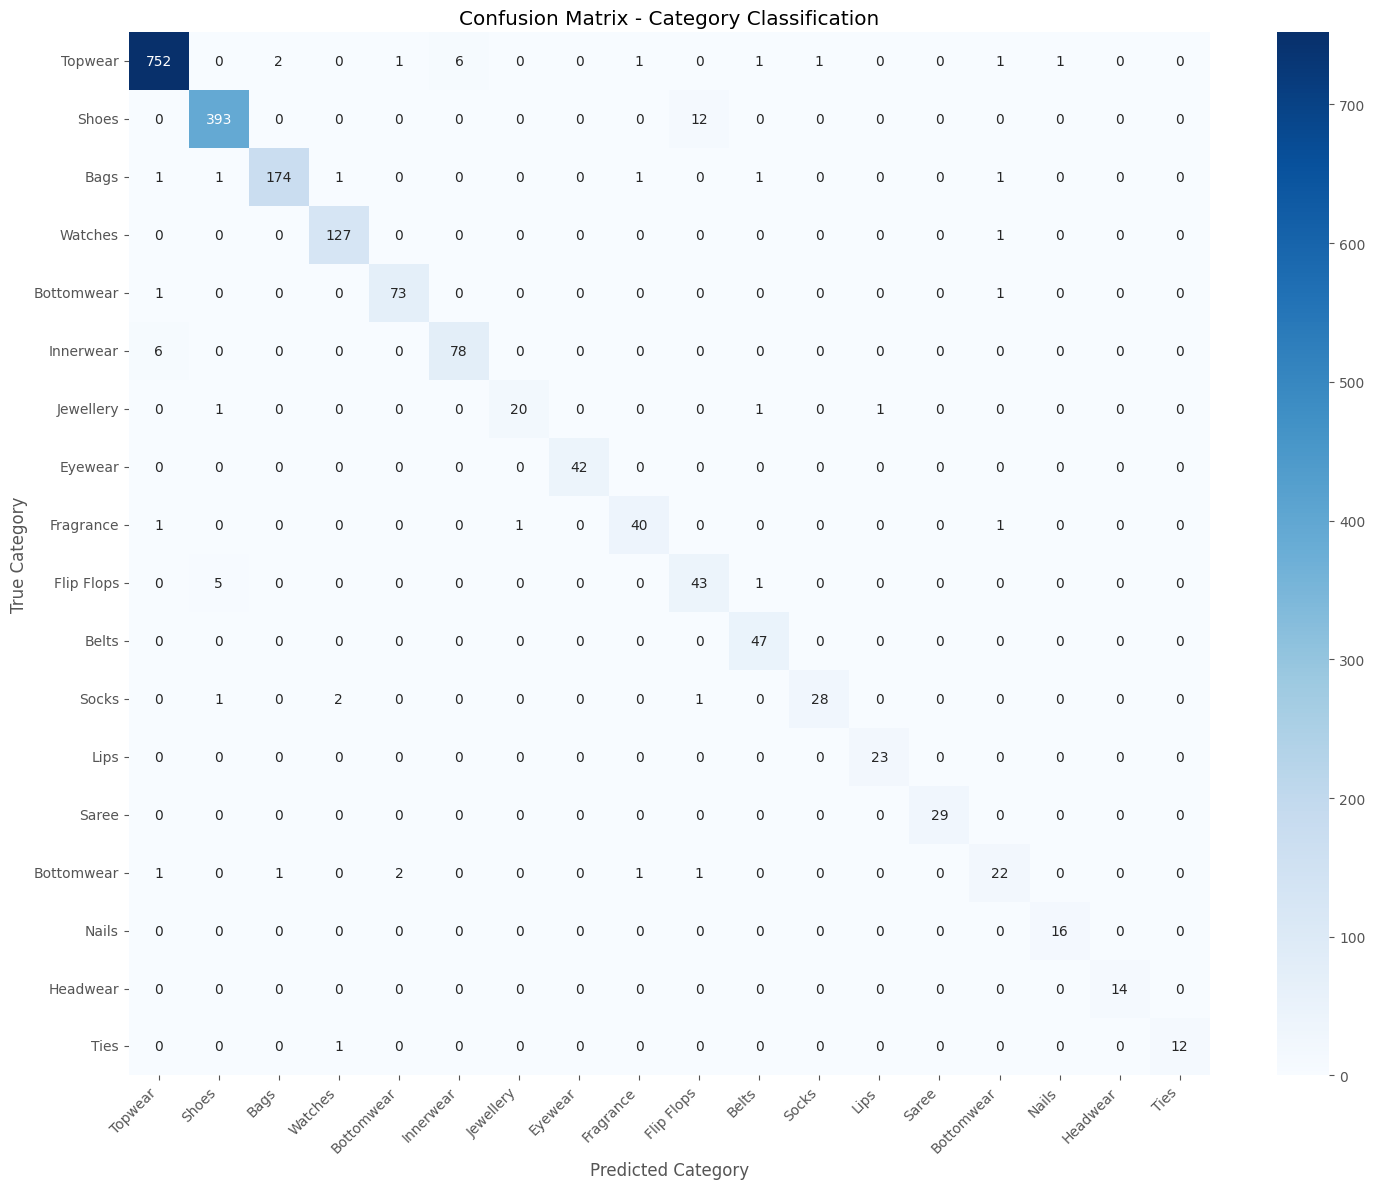


Performance Comparison:
Article-level accuracy: 0.792
Category-level accuracy: 0.968
Difference (Category - Article): 0.176


In [66]:
# Load the trained model from Task 2
model = FashionNetT2(embedding_dim=128)  # Use your actual model class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('task2_model.pth'))
model.to(device)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(main_test_dataset, batch_size=batch_size, shuffle=False)

# Create category mapping
article_to_category, category_names, article_names = create_article_to_category_mapping(train_dataset)

# Run hierarchical evaluation
compare_hierarchical_performance(model, train_loader, test_loader, 
                                article_to_category, category_names, device)